In [1]:
# data
import pandas as pd
import numpy as np

# PyMC (good for MCMC inference)
import pymc as pm
import pytensor as ptn

# pyro (uses torch, good for variational inference)
import pyro
import pyro.distributions as dist
import torch
import tqdm # progress bar

# numpyro (uses jax, good for MCMC and variational inference, but docs are a bit messy)
import numpyro
import numpyro.distributions as ndist
from numpyro.ops.indexing import Vindex
import jax
import jax.numpy as jnp

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import arviz as az

In [2]:
# setup
%config InlineBackend.figure_format = "retina"
rng = np.random.default_rng(14842)

# for numpyro
numpyro.set_host_device_count(2)
rng_key = jax.random.PRNGKey(14842)
# useful for debugging:
# jax.config.update("jax_debug_nans", True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Data

In [3]:
dists = pd.read_csv("bigrams.tsv", sep="\t", index_col=["piece", "staff", "bigram_id"])
dists

n0_tpc  n0_octave  n1_tpc  n1_octave  n0_midi  \
piece   staff bigram_id                                                  
chor001 1     0               1          4       1          4       67   
              1               1          4       2          5       67   
              2               2          5       5          4       74   
              3               5          4       3          4       71   
              4               3          4       1          4       69   
...                         ...        ...     ...        ...      ...   
chor100 4     56              2          3      -3          3       50   
              57             -3          3       2          3       51   
              58              2          3       0          3       50   
              59              0          3       2          3       48   
              60              2          3       1          2       50   

                         int_fifths  int_octaves  int_semitones  \
piece   staff bigram_id                                           
chor001 1     0                   0            0              0   
              1                   1            0              7   
              2                   3           -2             -3   
              3                  -2            1             -2   
              4                  -2            1             -2   
...                             ...          ...            ...   
chor100 4     56                 -5            3              1   
              57                  5           -3             -1   
              58                 -2            1             -2   
              59                  2           -1              2   
              60                 -1            0             -7   

                         dist_semitones  
piece   staff bigram_id                  
chor001 1     0                       0  
              1                       7  
              2                       3  
              3                       2  
              4                       2  
...                                 ...  
chor100 4     56                      1  
              57                      1  
              58                      2  
              59                      2  
              60                      7  

[22018 rows x 9 columns]

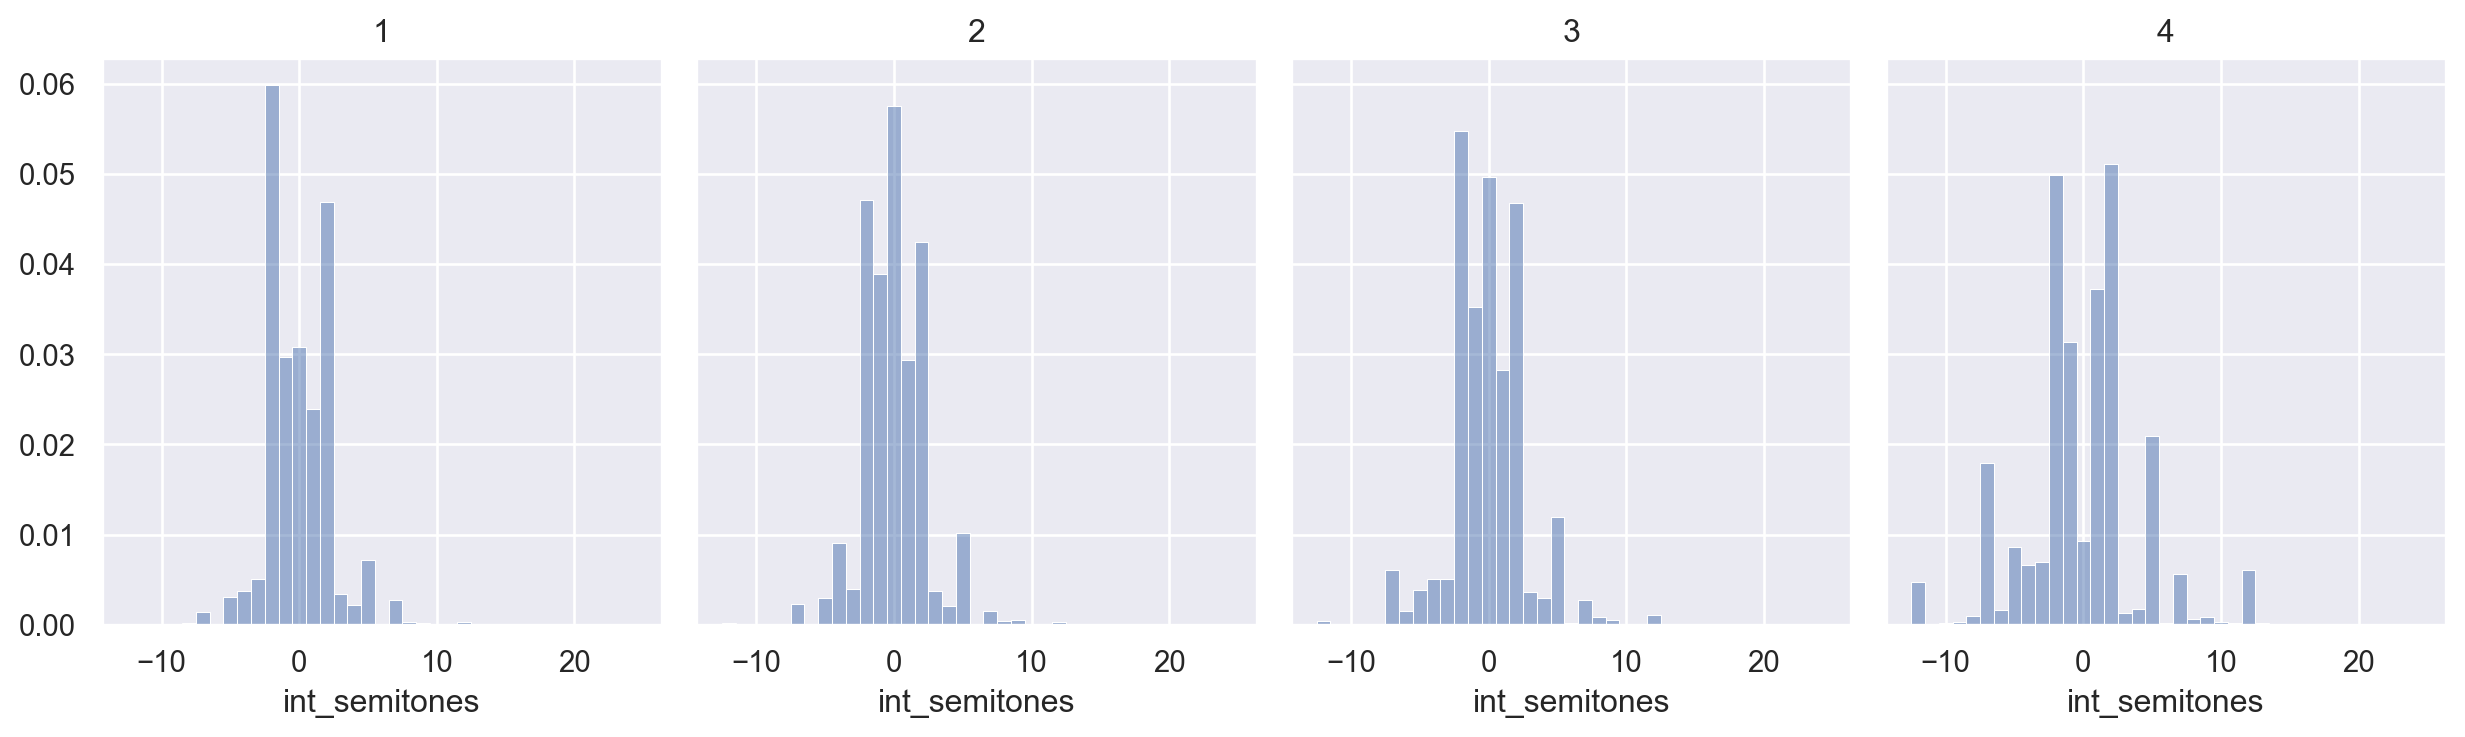

In [4]:
(
    so.Plot(dists, x="int_semitones")
        .facet("staff")
        .add(so.Bars(alpha=0.5), so.Hist("probability", discrete=True))
        #.add(so.Line(), so.KDE())
        .layout(size=(13,4))
)

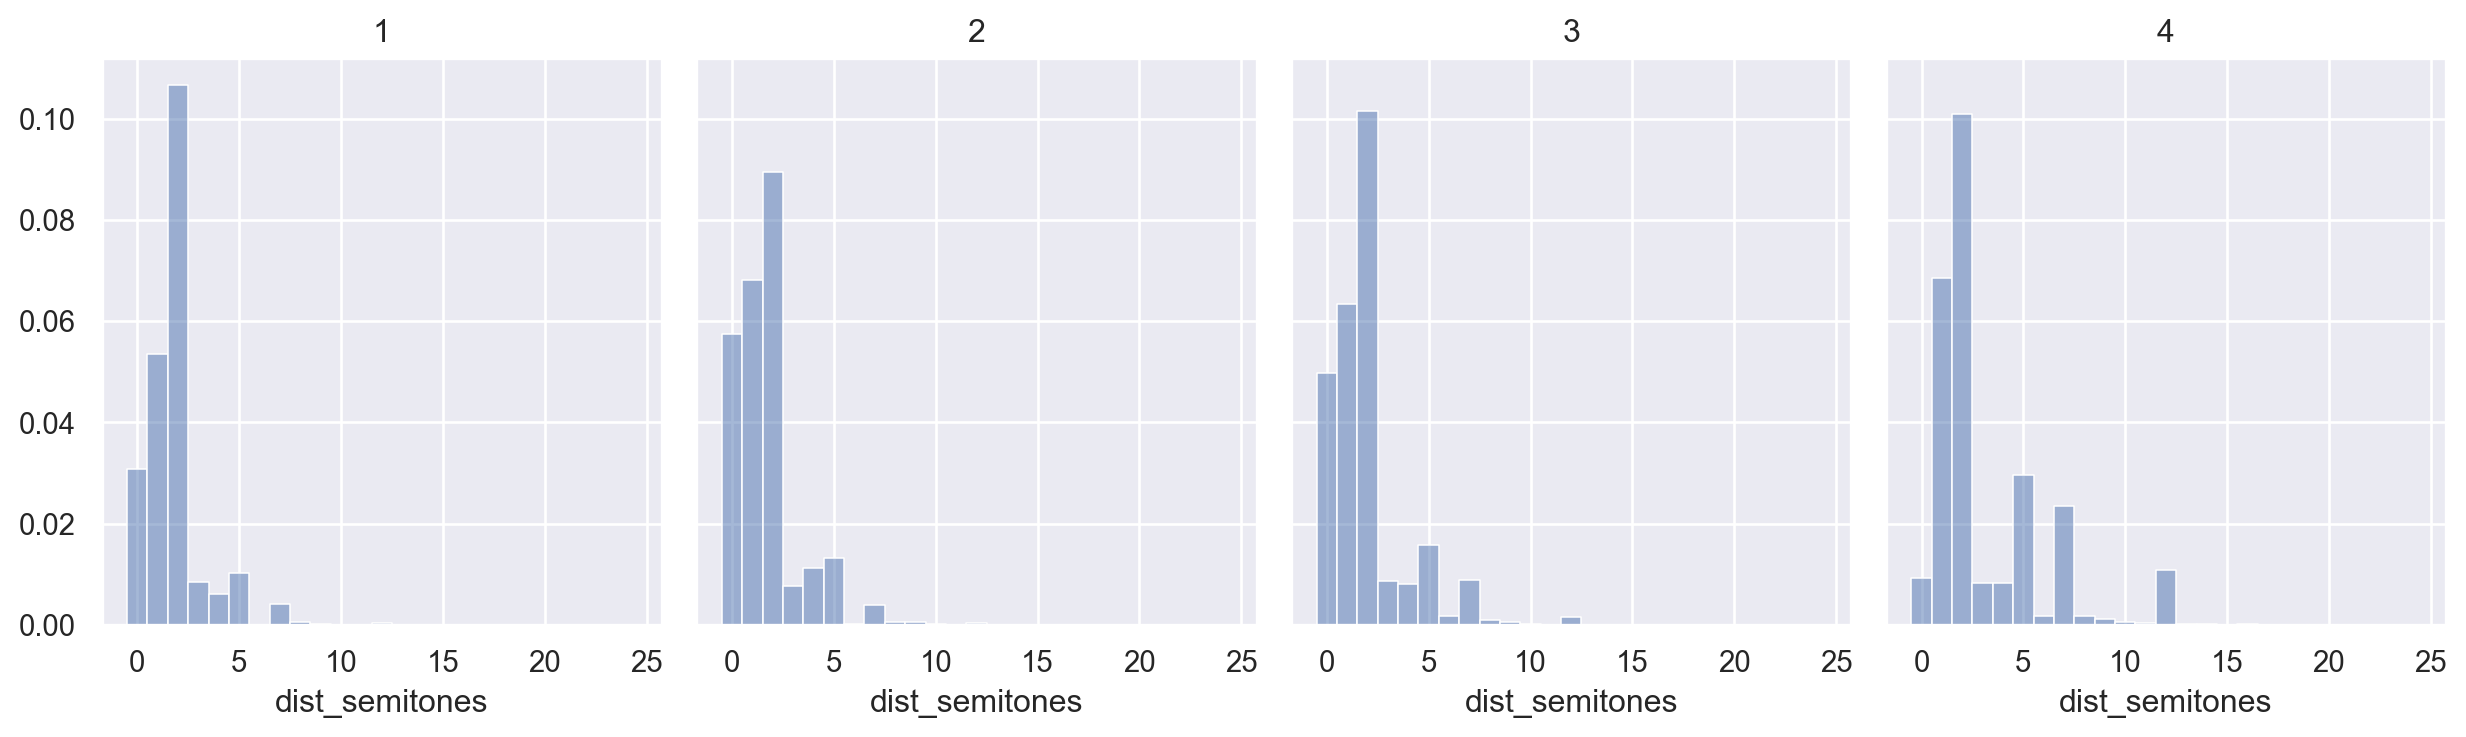

In [5]:
(
    so.Plot(dists, x="dist_semitones")
        .facet("staff")
        .add(so.Bars(alpha=0.5), so.Hist("probability", discrete=True))
        #.add(so.Line(), so.KDE())
        .layout(size=(13,4))
)

In [6]:
observations = np.array(dists["dist_semitones"].to_numpy())
observations

array([0, 7, 3, ..., 2, 2, 7])

In [7]:
staff = dists.index.get_level_values("staff").to_numpy()-1
staff

array([0, 0, 0, ..., 3, 3, 3])

In [8]:
p0 = dists["n0_midi"].to_numpy()
p0

array([67, 67, 74, ..., 50, 48, 50])

In [9]:
def estimate_beta(samples):
    mean = samples.mean(dim=["chain", "draw"]).to_numpy()
    var = samples.var(dim=["chain", "draw"]).to_numpy()
    common = (mean * (1-mean) / var) - 1
    alpha = common * mean
    beta = common * (1-mean)
    return alpha, beta

# Model 1: one global spread parameter

In [10]:
with pm.Model() as model_simple:
    theta = pm.Beta("theta_global", 0.5, 0.5)
    obs = pm.Geometric("obs", p=theta, observed=observations+1) # +1 for geometric distribution (starts at 1, not 0)

    idata_simple = pm.sample(5_000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_global]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


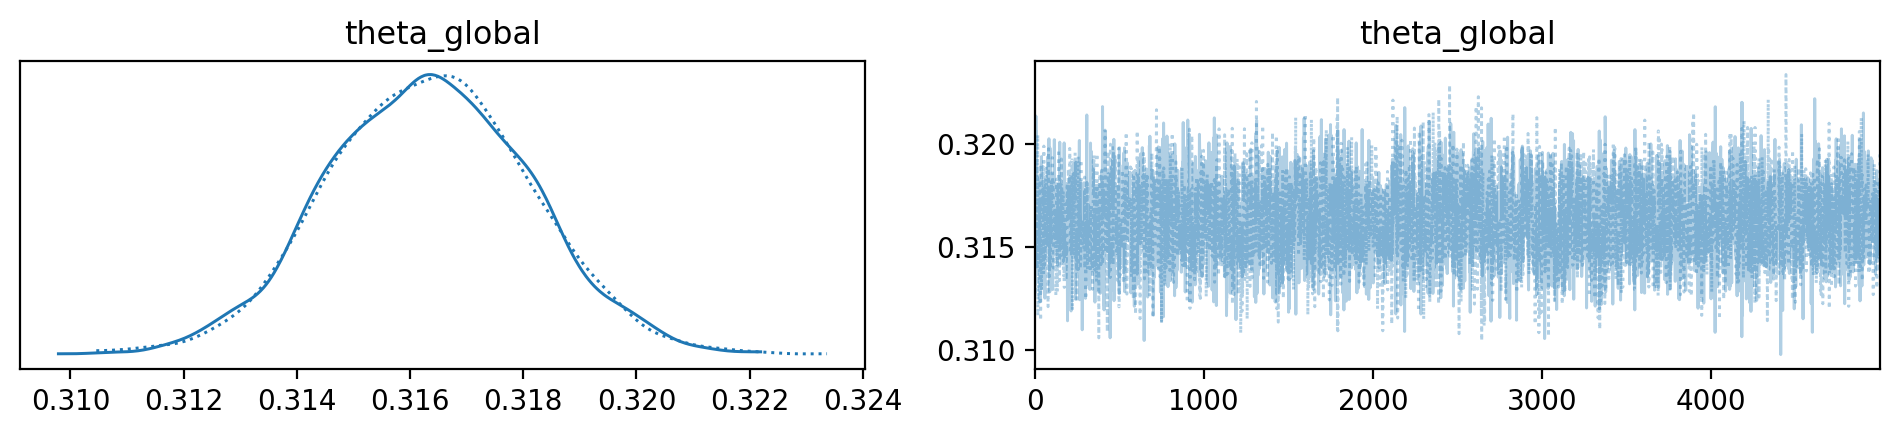

In [11]:
az.plot_trace(idata_simple);

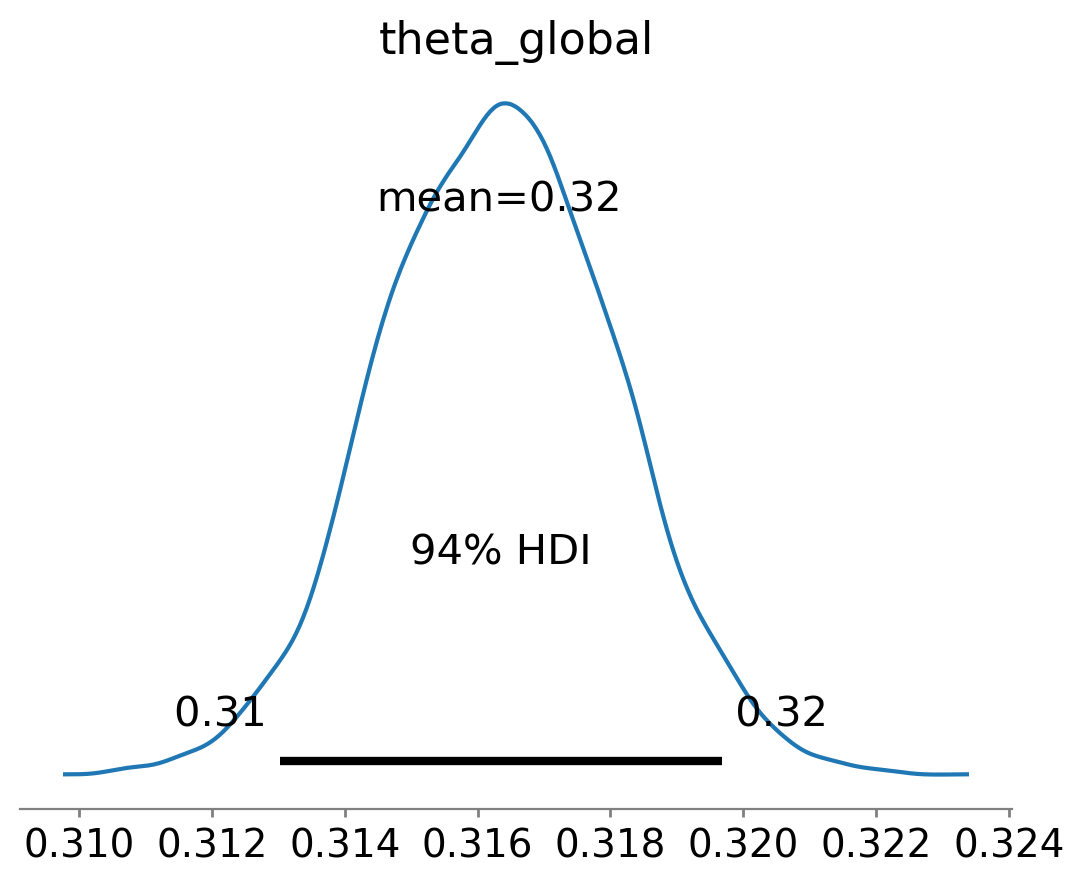

In [12]:
az.plot_posterior(idata_simple);

# Model 2: one parameter per voice

In [13]:
with pm.Model() as model_voice:
    staff_ = pm.MutableData("data_staff", staff)
    obs_ = pm.MutableData("data_obs", observations+1)
    theta = pm.Beta("theta_voice", 0.5, 0.5, shape=4)
    obs = pm.Geometric("obs", p=theta[staff_], observed=obs_) # +1 for geometric distribution (starts at 1, not 0)

    idata_voice = pm.sample(5_000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_voice]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 53 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


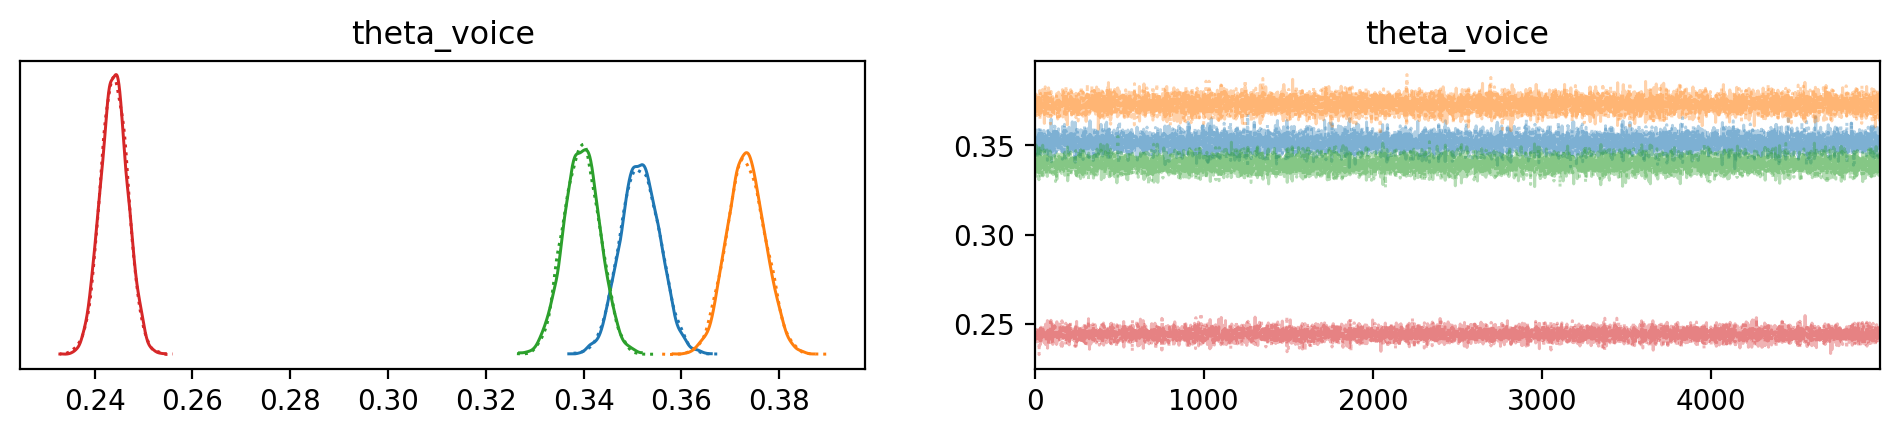

In [14]:
az.plot_trace(idata_voice);

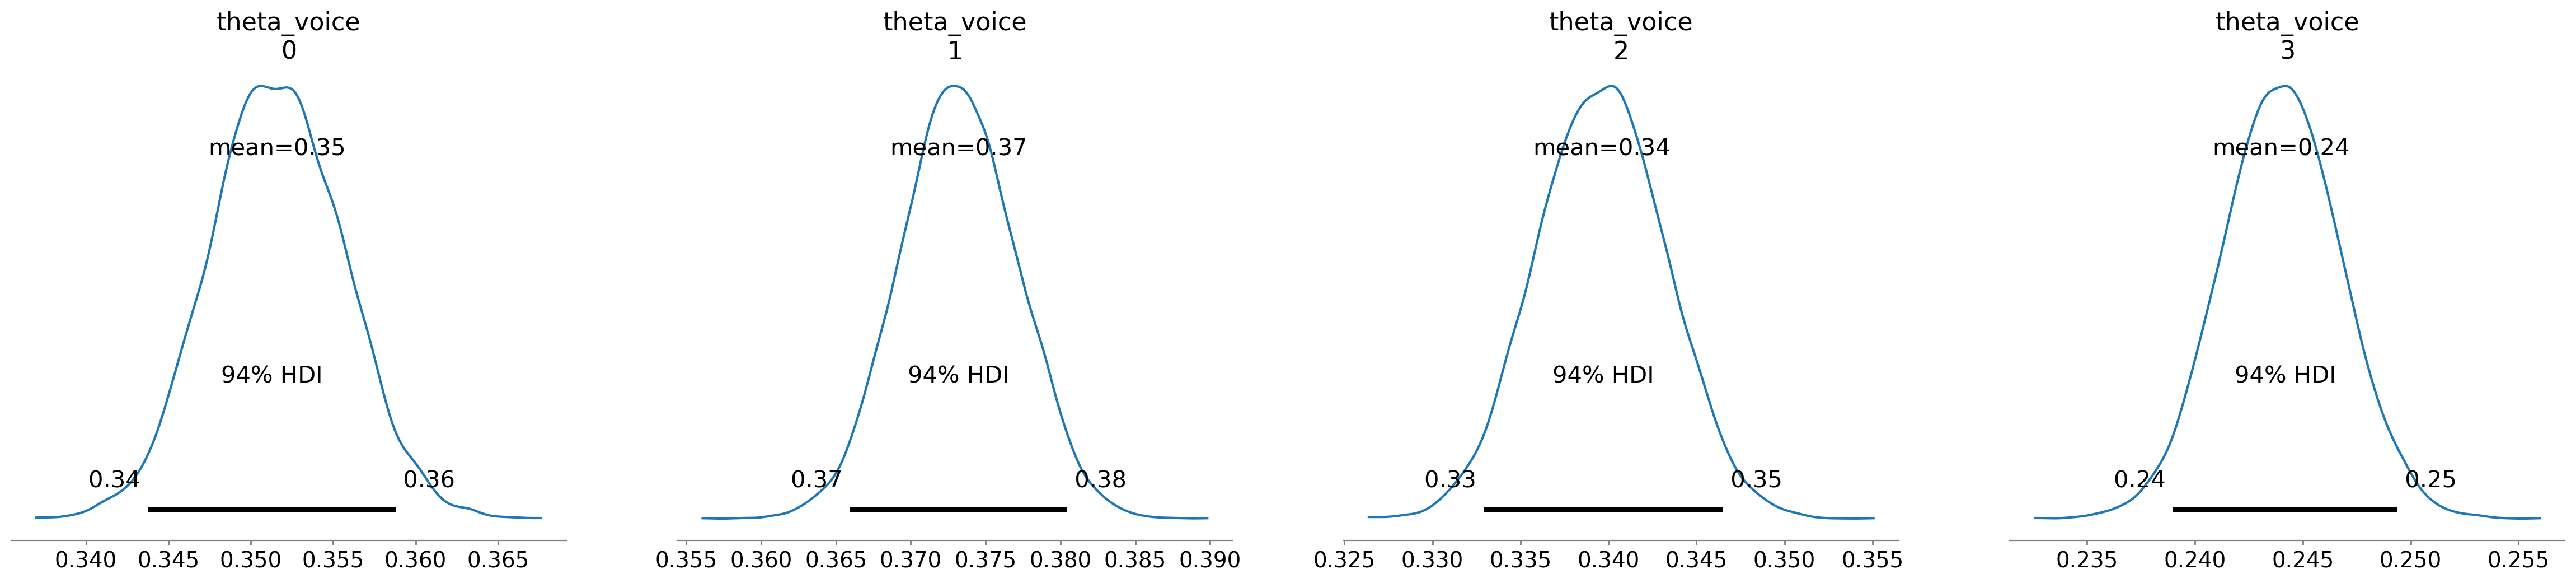

In [15]:
az.plot_posterior(idata_voice);

# Model 3: depend on register

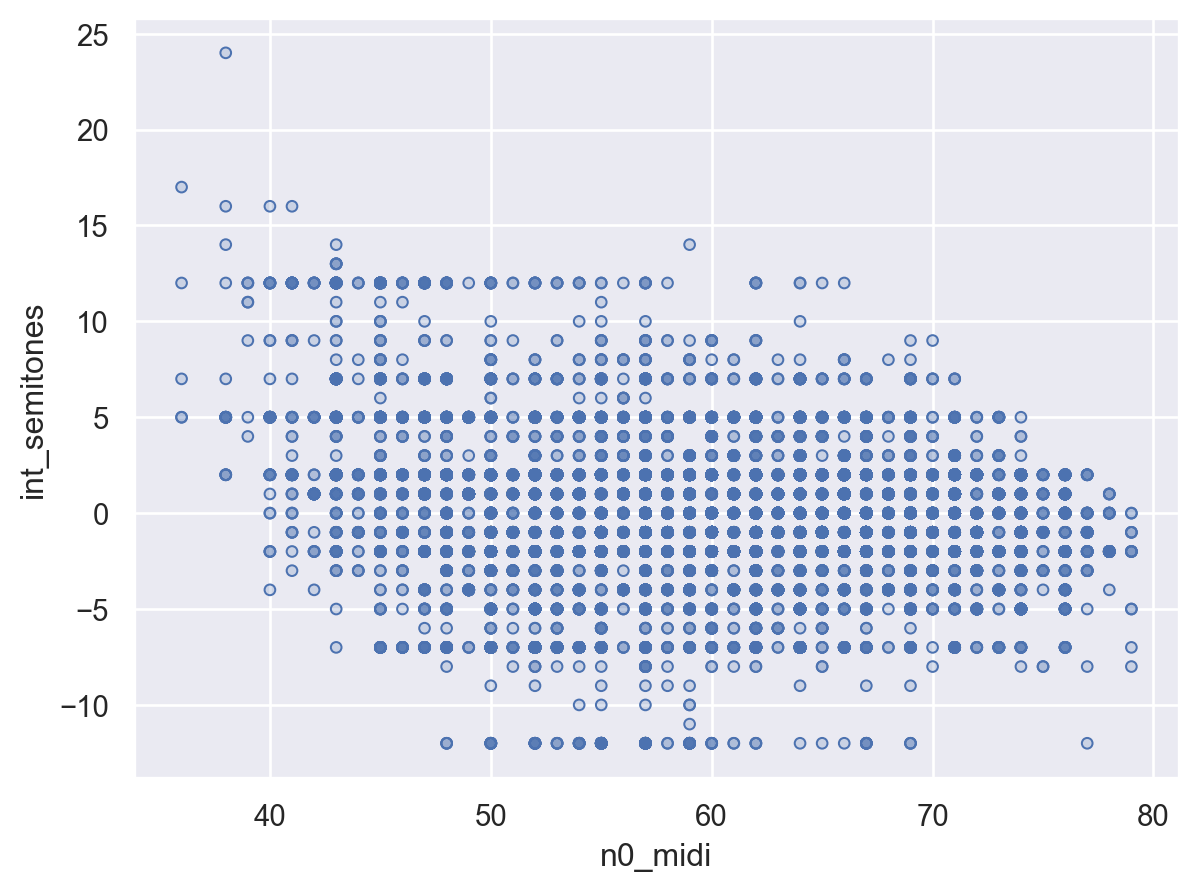

In [16]:
(
    so.Plot(dists, x="n0_midi", y="int_semitones").add(so.Dots())
)

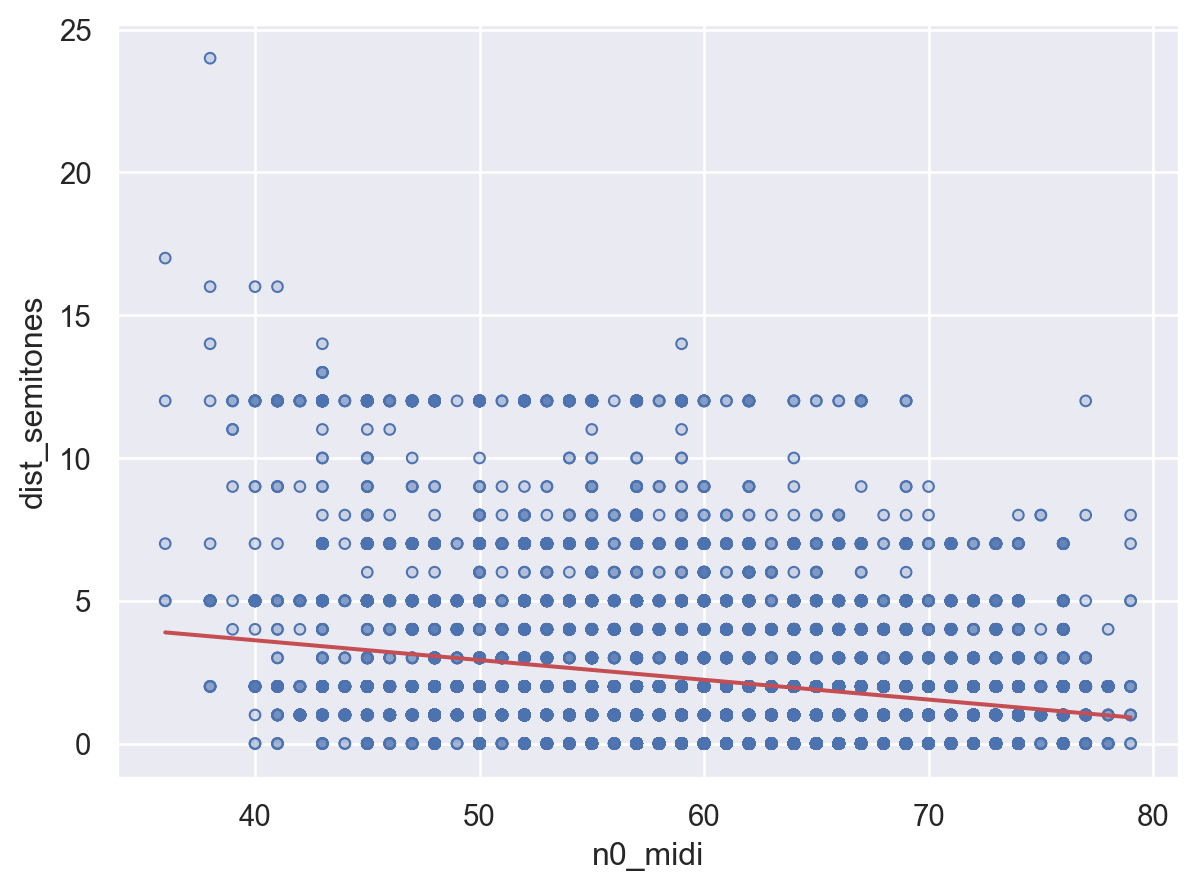

In [17]:
(
    so.Plot(dists, x="n0_midi", y="dist_semitones").add(so.Dots()).add(so.Line(color="r"), so.PolyFit(1))
)

In [18]:
with pm.Model() as model_register:
    p0_ = pm.MutableData("data_p0", p0)
    obs_ = pm.MutableData("data_obs", observations+1)
    a = pm.Normal("a", 0, 10)
    b = pm.Normal("b", 0, 10)
    theta = pm.math.sigmoid(p0_*a + b)
    obs = pm.Geometric("obs", p=theta, observed=obs_)

    idata_register = pm.sample(5_000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 501 seconds.


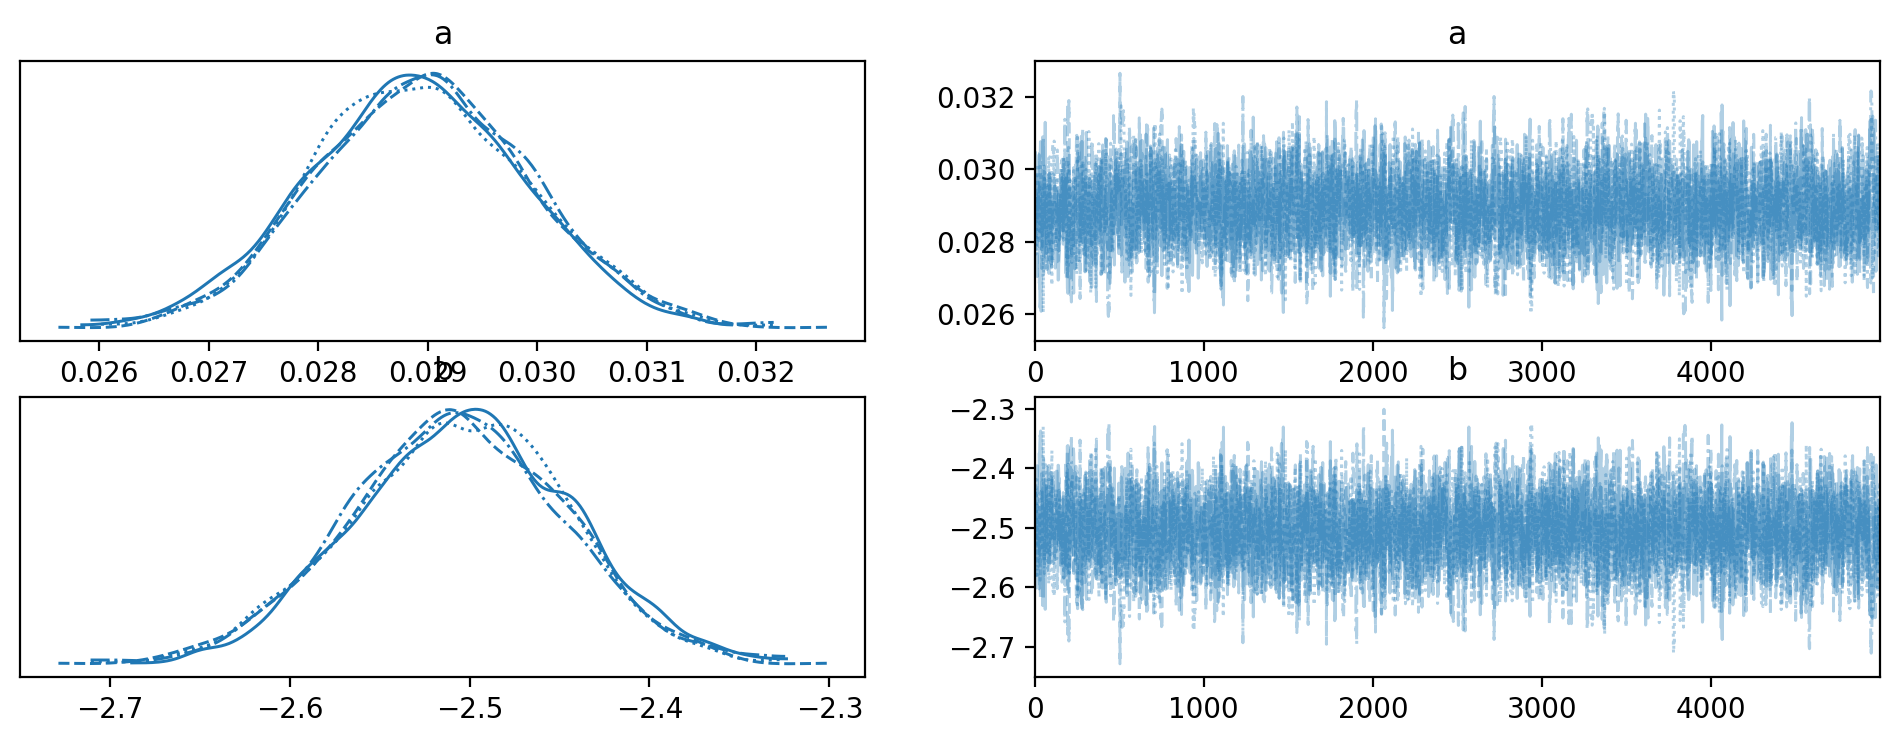

In [19]:
az.plot_trace(idata_register);

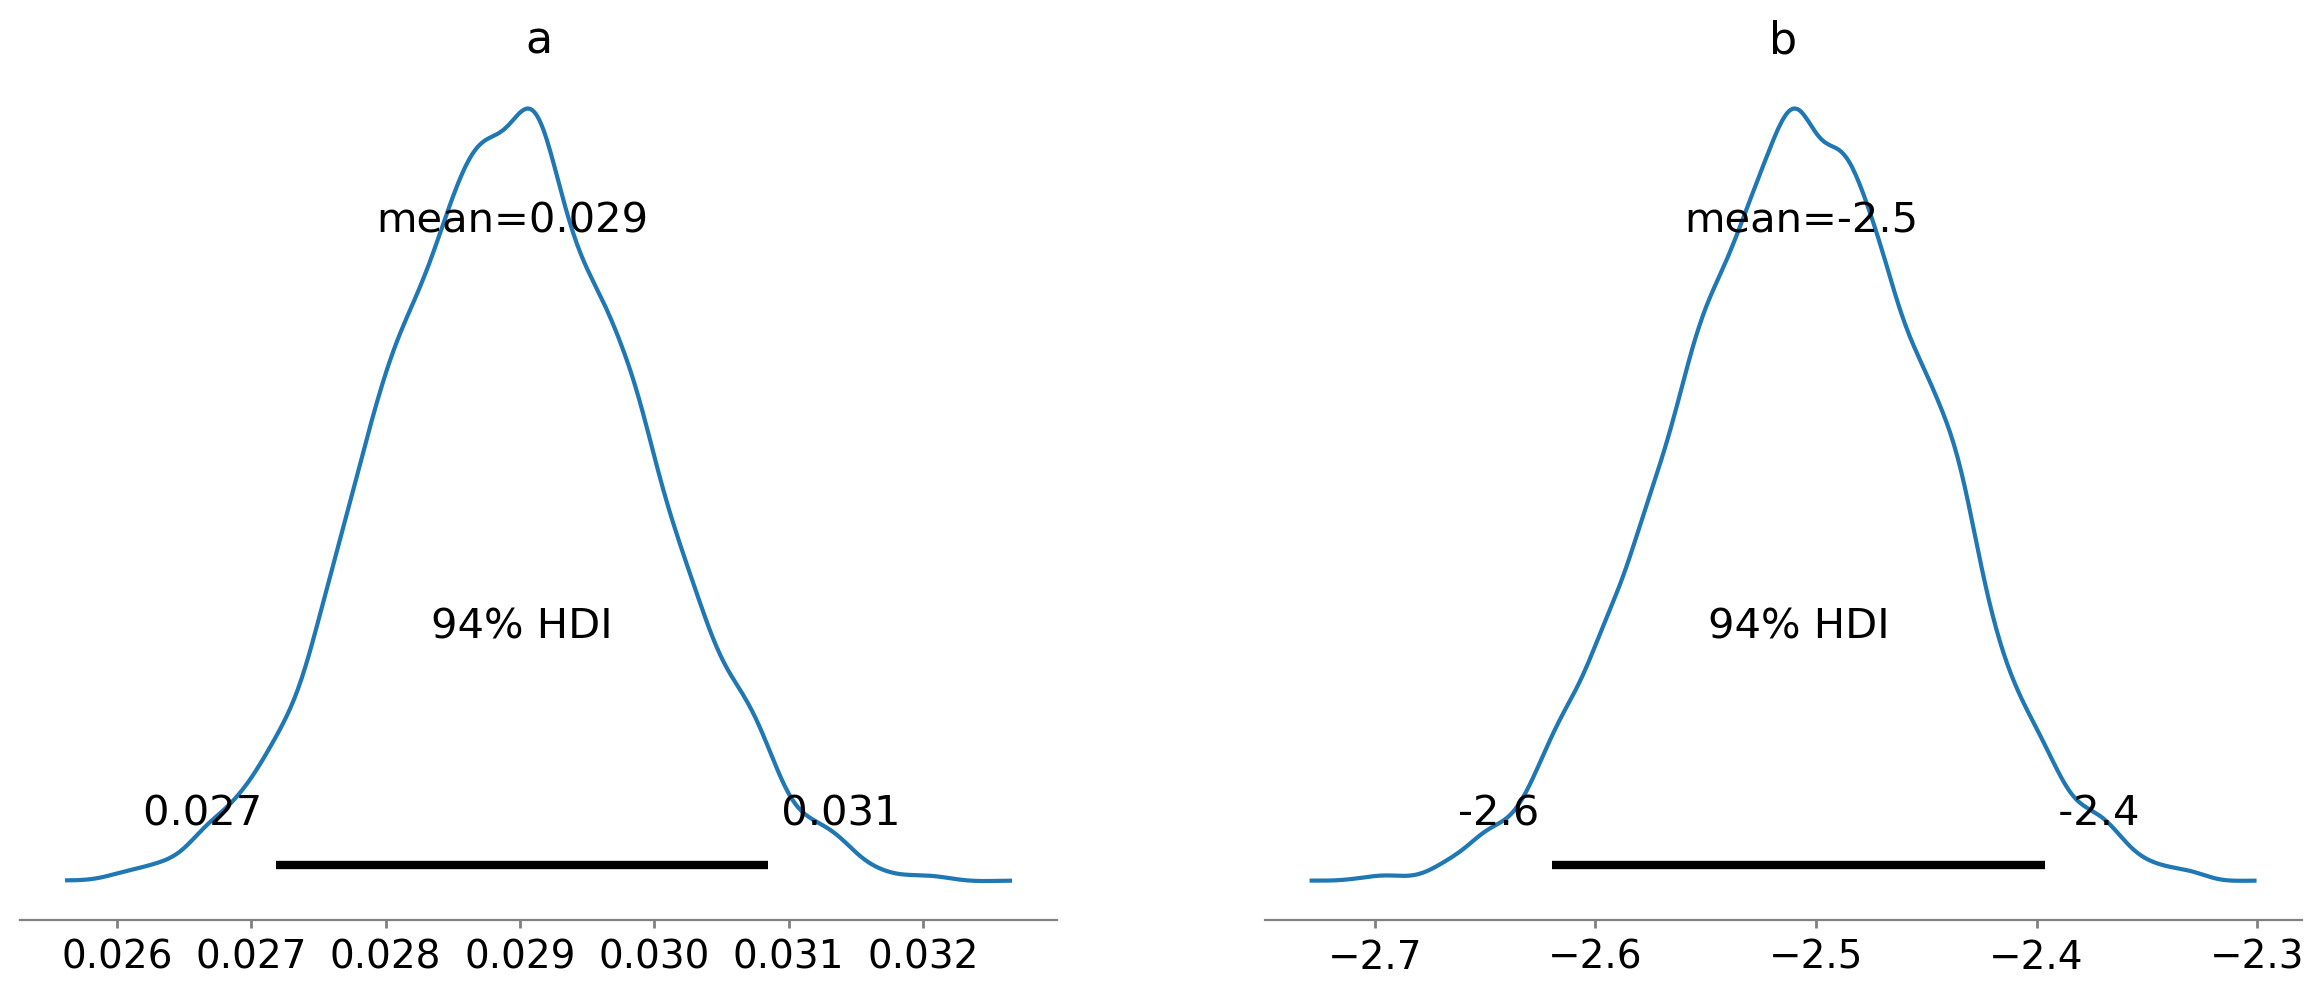

In [20]:
az.plot_posterior(idata_register);

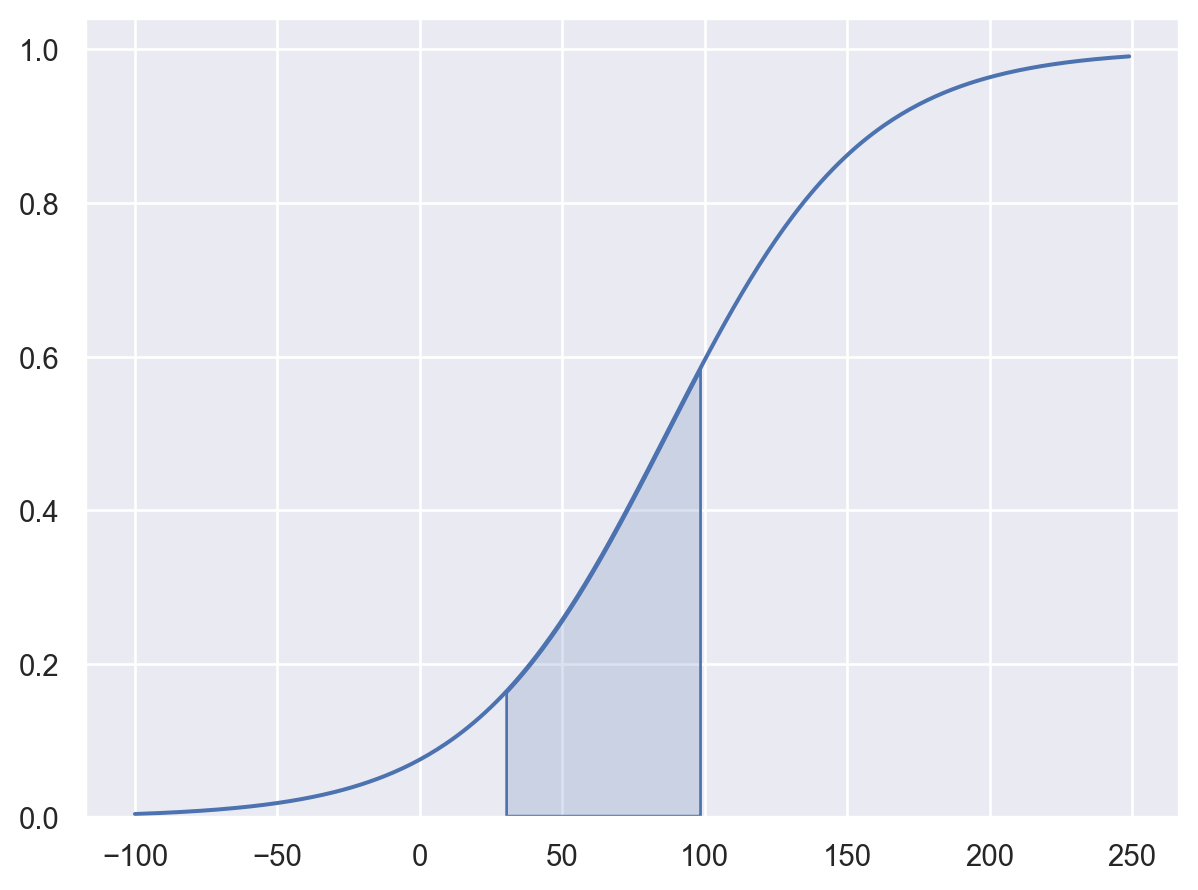

In [21]:
def plot_sigmoid(a, b):
    x = np.arange(-100,250)
    # y = 1 / (1 + np.exp(-(a*x + b)))
    y = pm.math.sigmoid(x*a + b).eval()
    return so.Plot(x=x, y=y).add(so.Line()).add(so.Area(), x=x[130:200], y=y[130:200])

plot_sigmoid(idata_register.posterior["a"].mean().item(), idata_register.posterior["b"].mean().item())

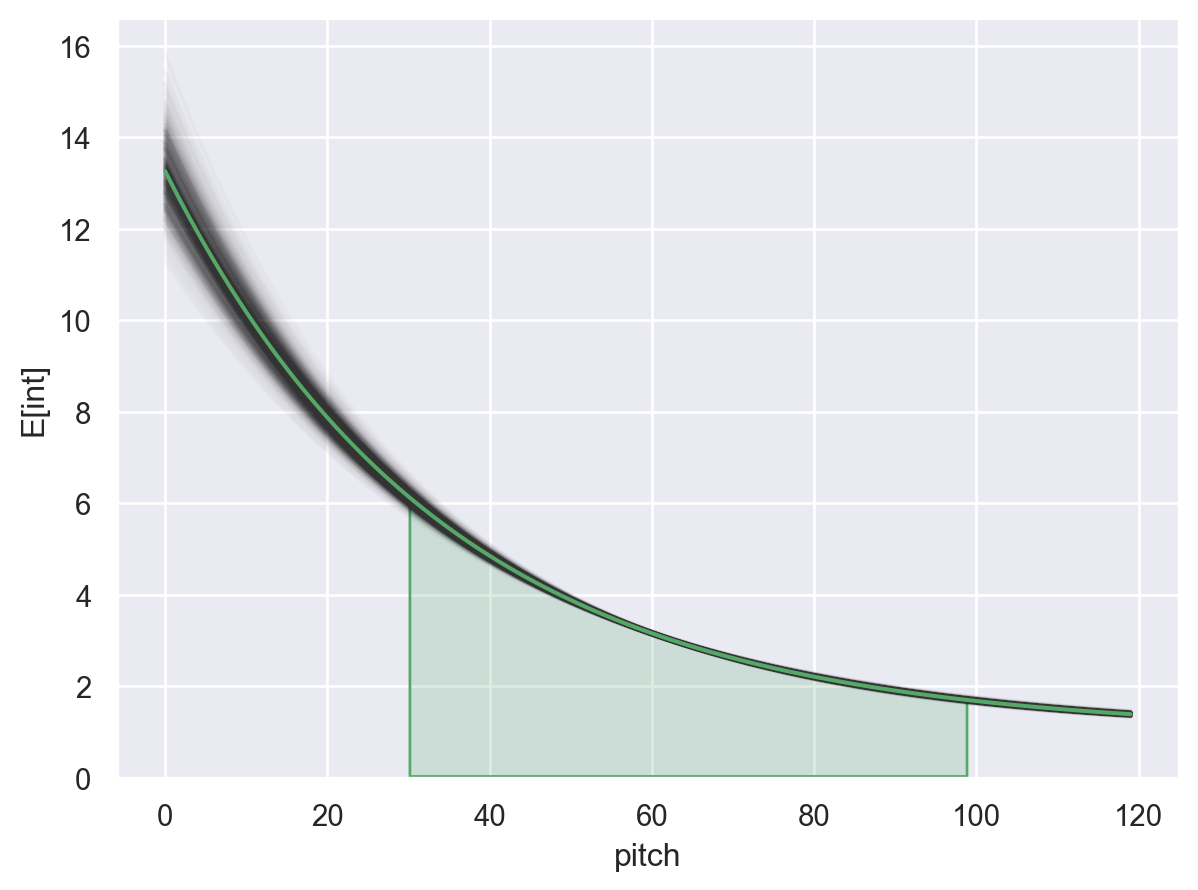

In [22]:
def plot_sigmoids(a, b):
    # select some samples
    ny = 1_000
    indices = rng.choice(np.arange(a.size), ny, replace=False)

    # compute the sigmoids for the selected samples
    x = np.arange(0,120)
    y = (1 + np.exp(-(np.atleast_2d(a[indices]).T * np.atleast_2d(x) + np.atleast_2d(b[indices]).T)))

    # create a dataframe that holds the sample sigmoids, this makes it easier to plot with seaborn
    data = pd.DataFrame({
        "pitch": np.tile(x, ny),
        "E[int]": y.flatten(),
        "group": np.concatenate([np.full(x.size, iy) for iy in range(ny)])
    })
    
    # compute the sigmoid for the sample mean over all samples (same as previous plot)
    amean = a.mean()
    bmean = b.mean()
    ymean = (1 + np.exp(-(amean*x + bmean)))

    # create the plot with sample sigmoids and mean sigmoid
    return (
        so.Plot()
            .add(so.Line(alpha=0.01, color=".2"), data=data, x="pitch", y="E[int]", group="group")
            .add(so.Line(color="g"), x=x, y=ymean)
            .add(so.Area(color="g"), x=x[30:100], y=ymean[30:100])
    )

plot_sigmoids(idata_register.posterior["a"].to_numpy().flatten(), idata_register.posterior["b"].to_numpy().flatten())

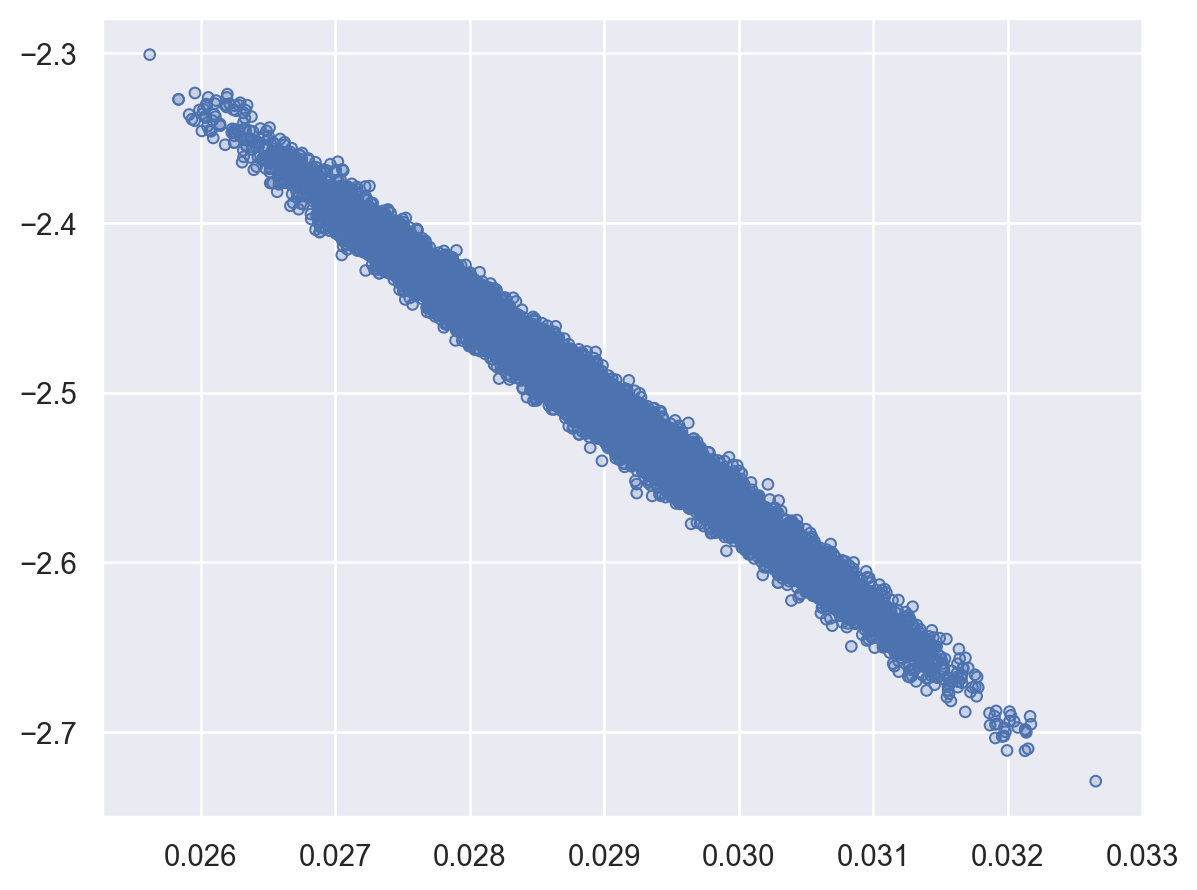

In [23]:
so.Plot(x=idata_register.posterior["a"].to_numpy().flatten(), y=idata_register.posterior["b"].to_numpy().flatten()).add(so.Dots())

# Checking the model: simulate data

## By Voice

In [24]:
with model_voice:
    pm.set_data({"data_staff": [0,1,2,3], "data_obs": [1, 1, 1, 1]})
    pm.sample_posterior_predictive(idata_voice, extend_inferencedata=True)

idata_voice

Sampling: [obs]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

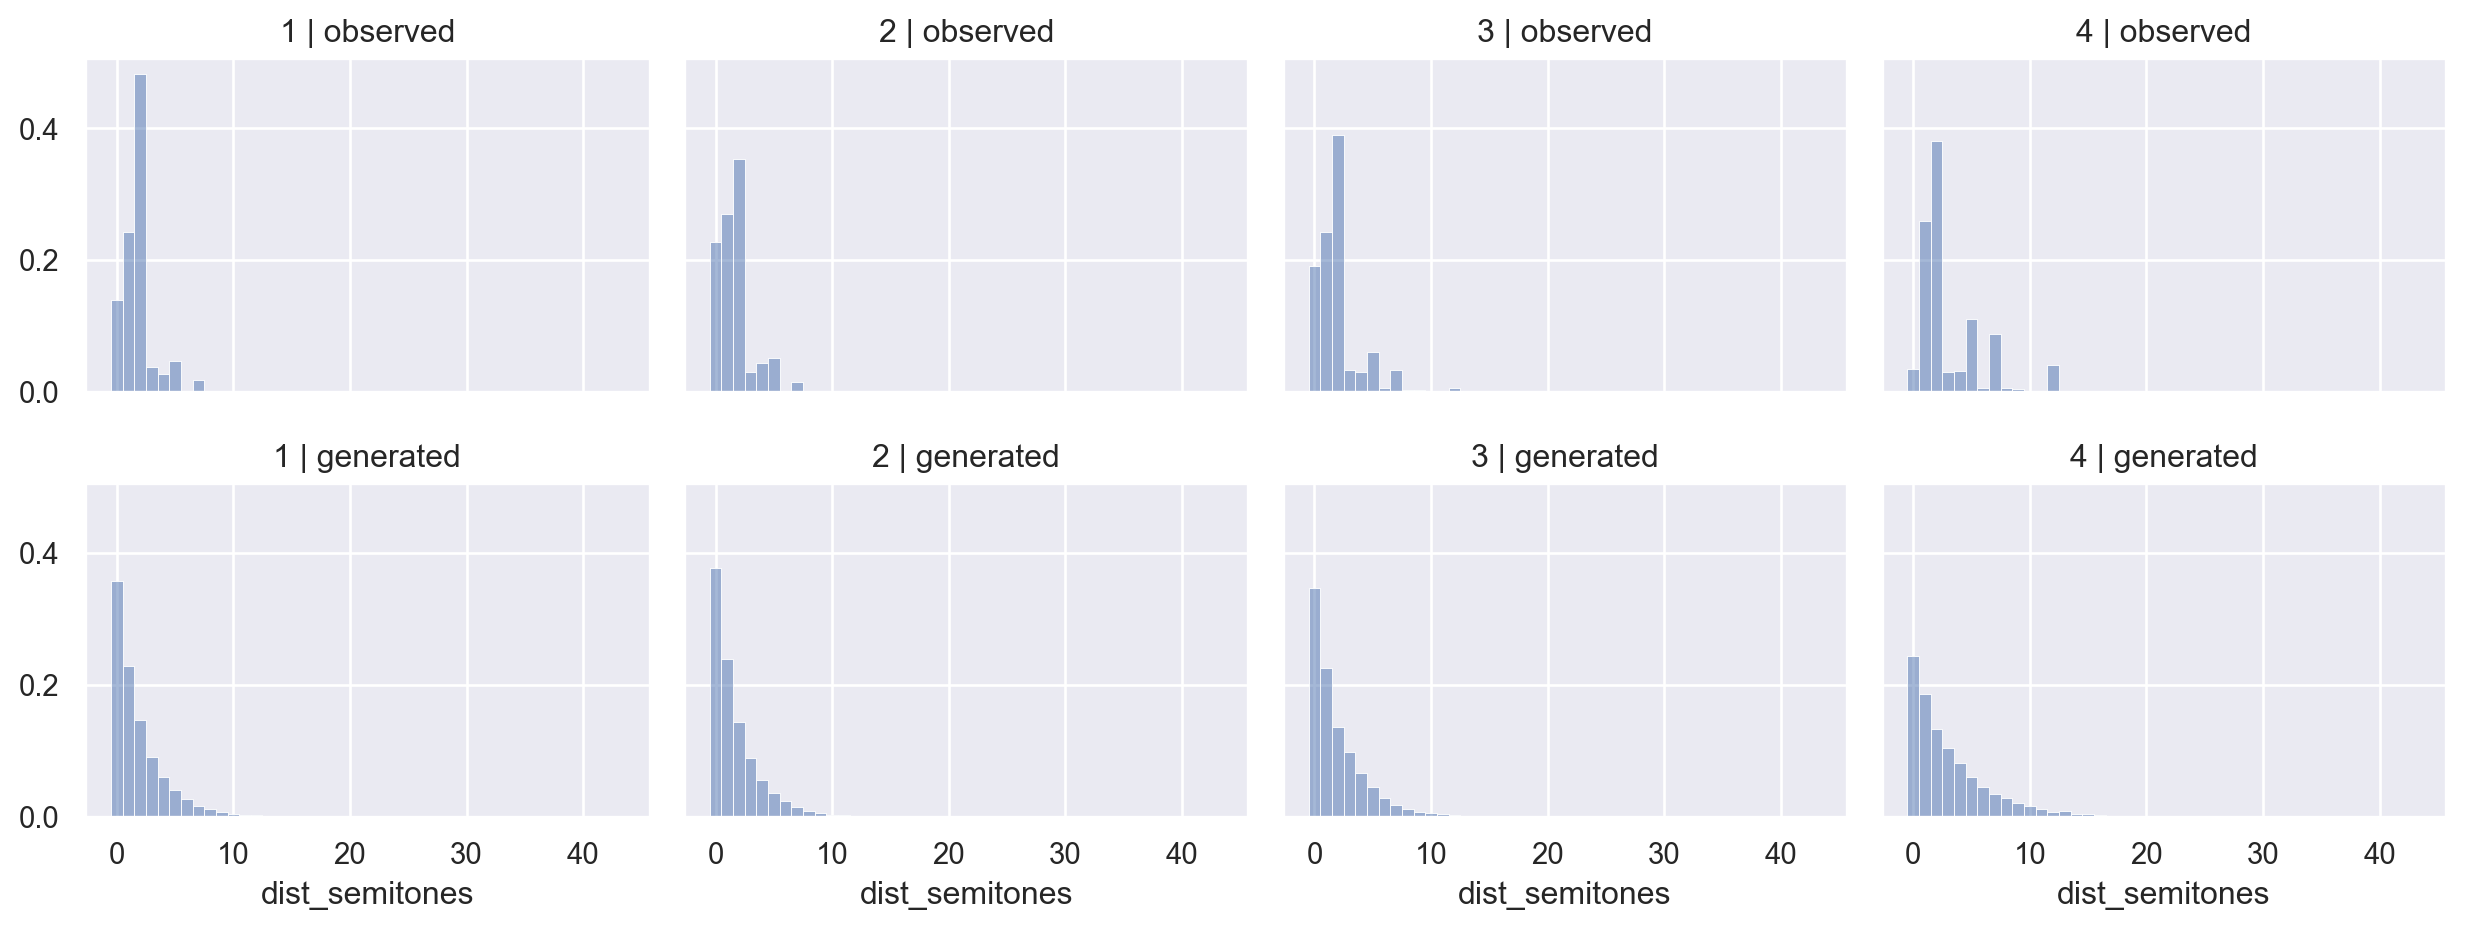

In [25]:
def plot_compare_voice(idata, original):
    gen_samples = idata.posterior_predictive["obs"].to_numpy().flatten()
    n_chains = idata.posterior_predictive.dims["chain"]
    n_draws = idata.posterior_predictive.dims["draw"]
    gen_df = pd.DataFrame({
        "staff": np.tile([1,2,3,4], n_chains * n_draws),
        "dist_semitones": gen_samples-1,
        #"bigram_id": np.repeat(np.arange(n_chains * n_draws), 4)
    })
    df_voice = pd.concat((original.reset_index(), gen_df),
                         join="inner",
                         keys=["observed", "generated"],
                         names=["source", "sample"])

    return (
        so.Plot(df_voice, x="dist_semitones")
            .facet(row="source", col="staff")
            .add(so.Bars(alpha=0.5), so.Hist("density", discrete=True))
            #.add(so.Line(), so.KDE())
            .layout(size=(13,5))
    )

plot_compare_voice(idata_voice, dists)

## By Register

In [26]:
p0_range = np.arange(p0.min(), p0.max()+1)

with model_register:
    pm.set_data({"data_p0": p0_range, "data_obs": np.ones(p0_range.shape, dtype=int)})
    pm.sample_posterior_predictive(idata_register, extend_inferencedata=True)

idata_register

Sampling: [obs]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

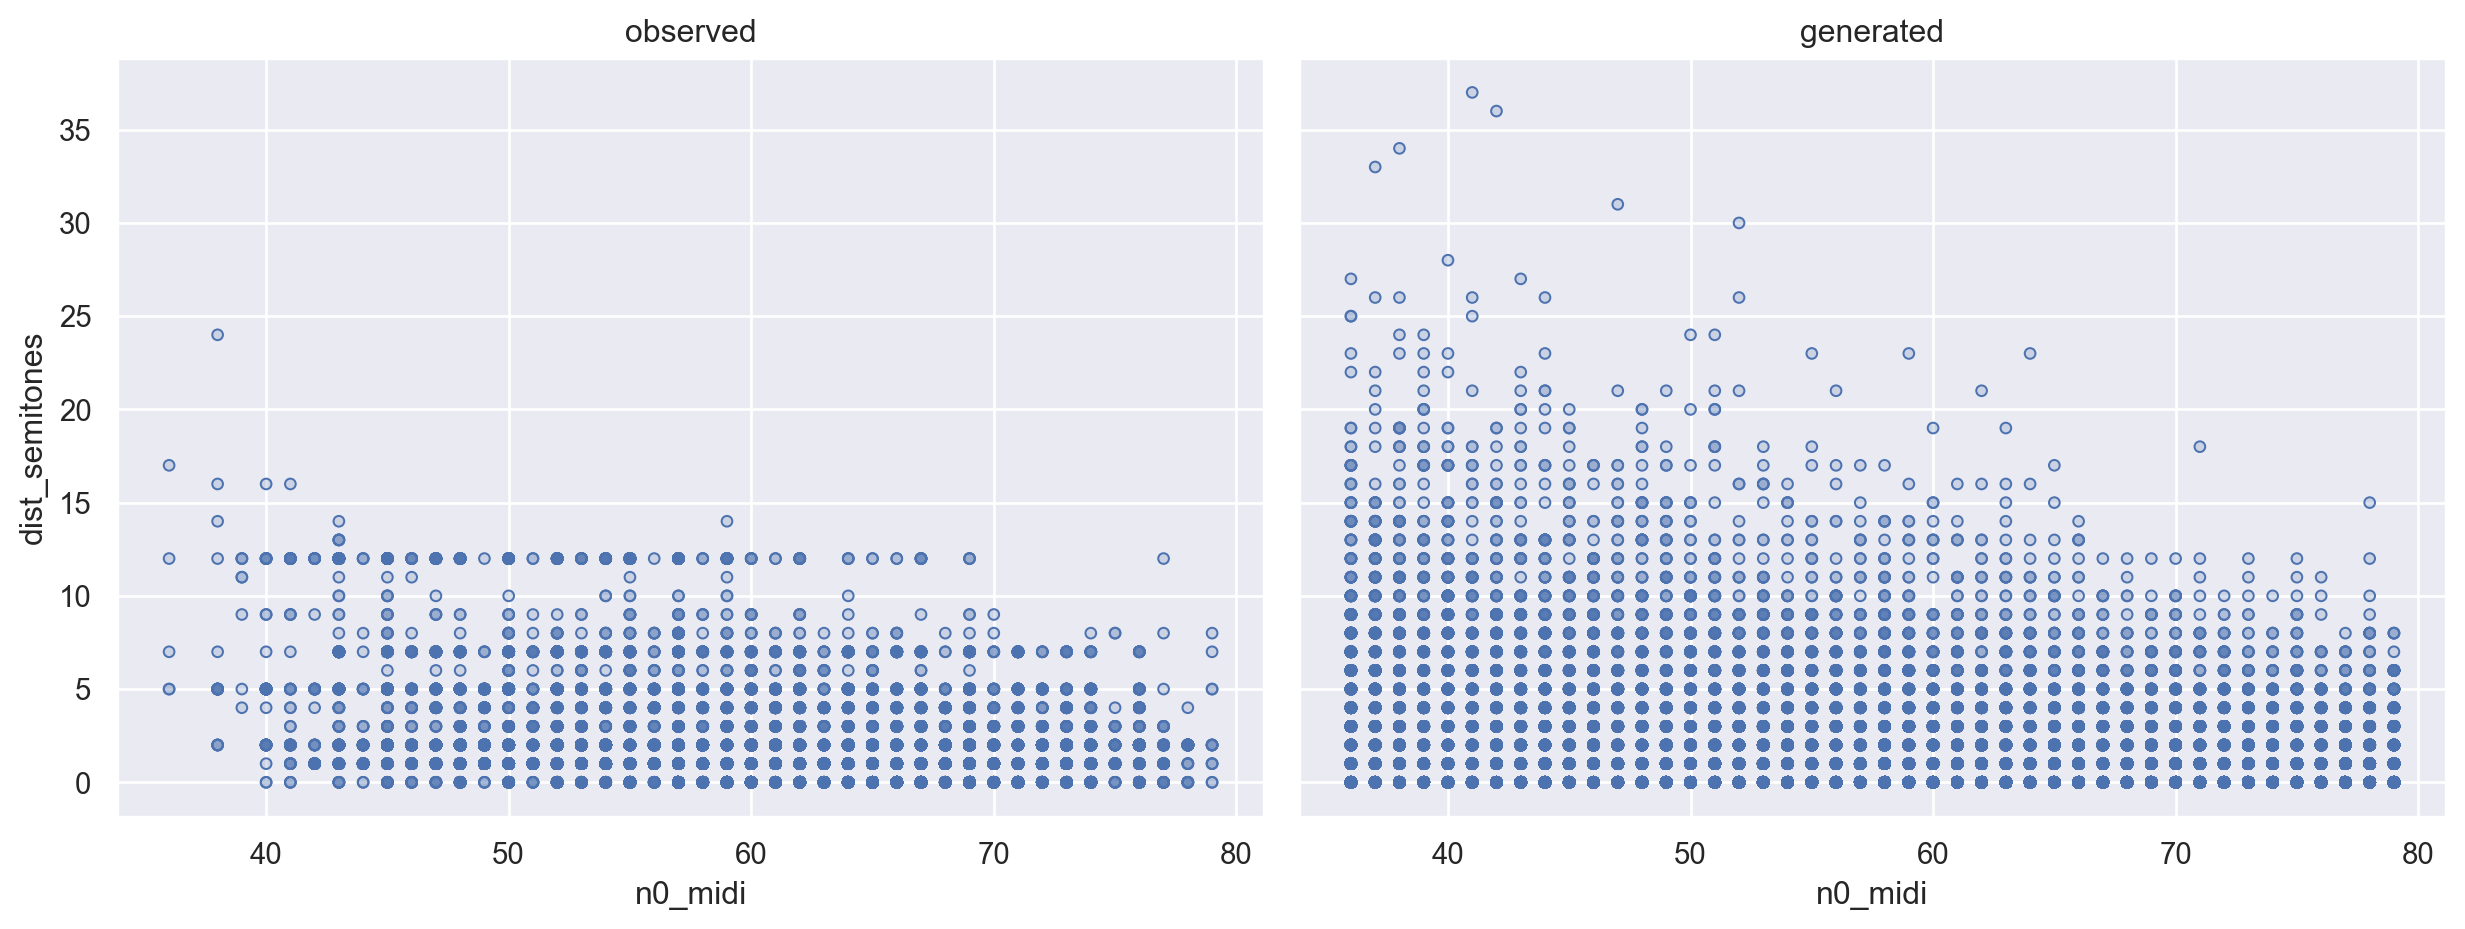

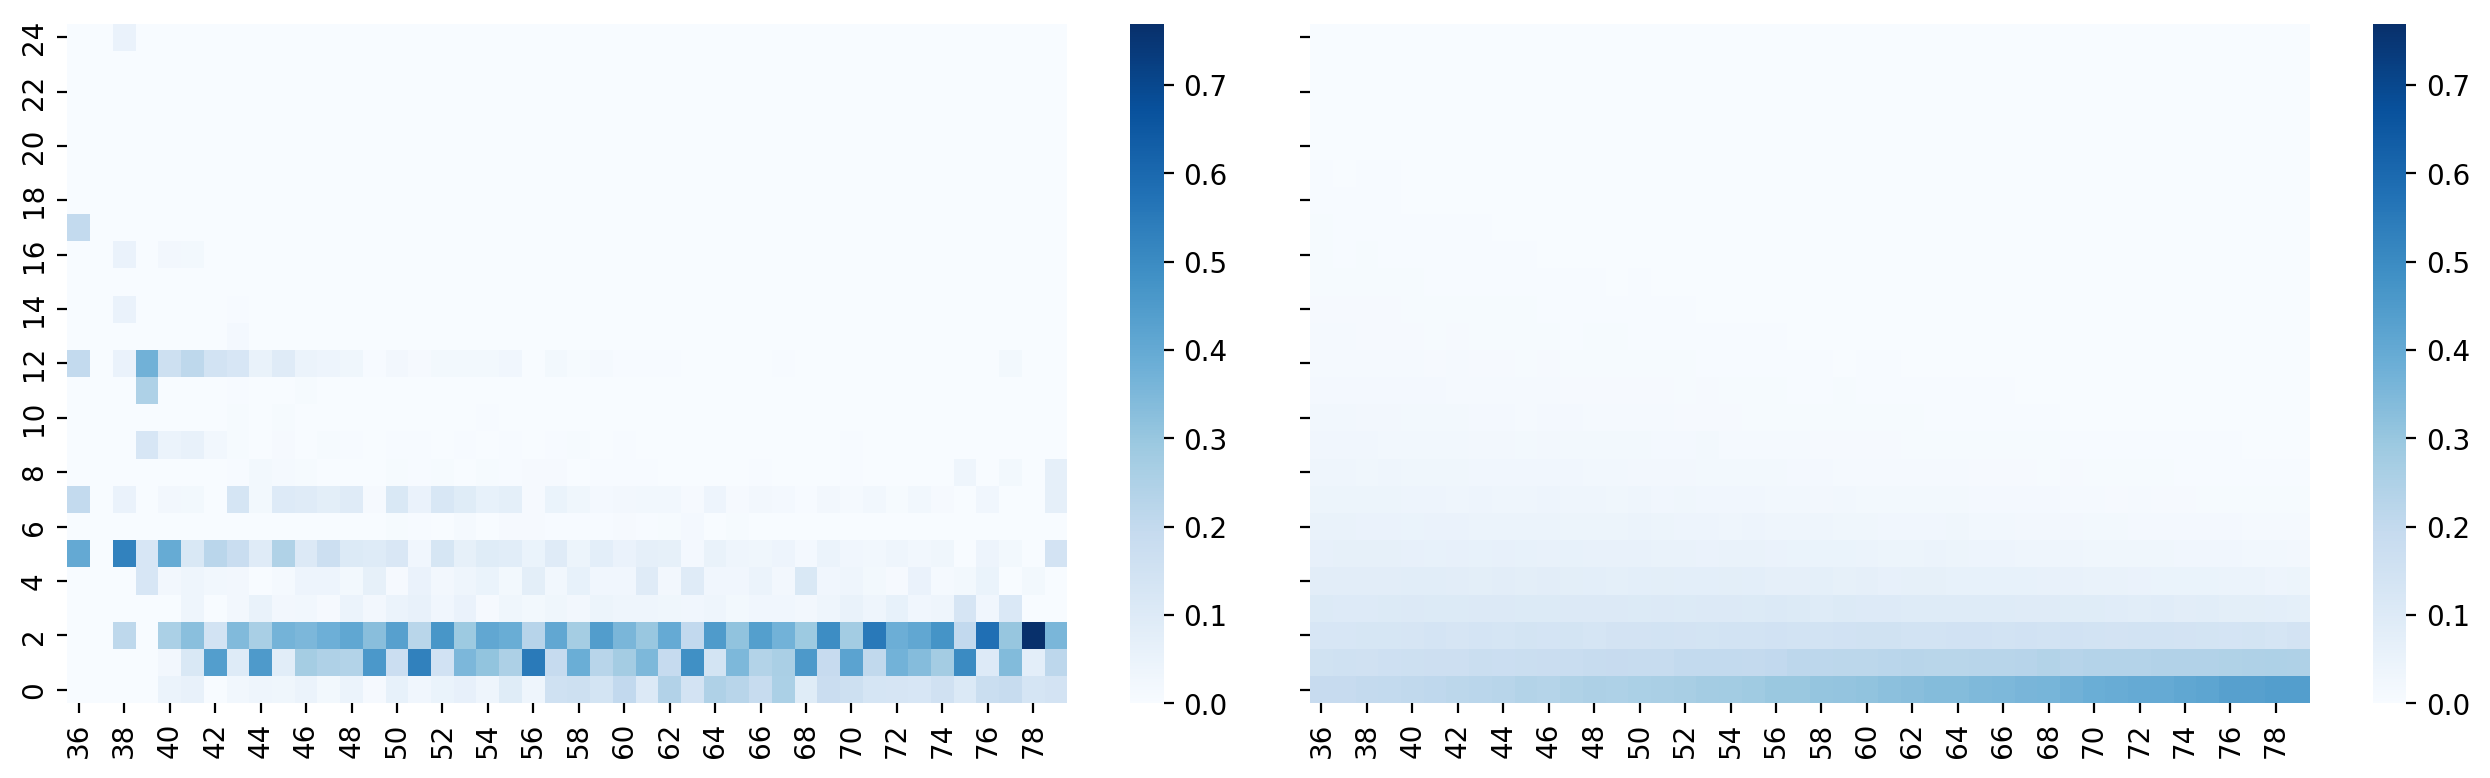

In [27]:
def plot_data_vs_generated(idata, original):
    gen_register = idata.posterior_predictive["obs"].to_numpy().flatten()
    n_chains = idata.posterior_predictive.dims["chain"]
    n_draws = idata.posterior_predictive.dims["draw"]
    gen_df = pd.DataFrame({
        "n0_midi": np.tile(p0_range, n_chains*n_draws),
        "dist_semitones": gen_register.flatten()-1,
        #"sample": np.repeat(np.arange(n_chains*n_draws), len(p0_range))
    })
    # combine dataframes, downsample generated to common size
    subsample = rng.choice(np.arange(len(p0_range)*n_chains*n_draws), len(original), replace=False)
    df = pd.concat([original.reset_index(), gen_df.iloc[subsample]], join="inner", keys=["observed", "generated"], names=["source", "sample"])

    def cond_hist(data):
        p0 = data.n0_midi
        dist = data.dist_semitones
        xmin, xmax = p0.min(), p0.max()
        ymin, ymax = dist.min(), min(24, dist.max())
        
        hist, xedges, yedges = np.histogram2d(p0, dist, range=[[xmin-0.5, xmax+0.5], [ymin-0.5, ymax+0.5]], bins=(xmax-xmin+1, ymax-ymin+1))
        marg = hist.sum(axis=1, keepdims=True)
        marg[marg==0] = 1
        hist_cond = hist / marg
        return pd.DataFrame(data=hist_cond.T, columns=np.arange(xmin, xmax+1), index=np.arange(ymin, ymax+1))
        
    def plot_hist(ax, df, vmax, cbar=True):
        sns.heatmap(df, ax=ax, cmap="Blues", vmin=0, vmax=vmax, cbar=cbar)

    hist_orig = cond_hist(original)
    hist_gen = cond_hist(gen_df)
    vmax = max(hist_orig.max(axis=None), hist_gen.max(axis=None))
    
    fig, ax = plt.subplots(1, 2, figsize=(13,4), sharex=True, sharey=True)
    plot_hist(ax[0], hist_orig, vmax)
    plot_hist(ax[1], hist_gen, vmax)
    ax[0].invert_yaxis()
    fig.tight_layout()
    # return fig
    return so.Plot(df, x="n0_midi", y="dist_semitones").facet("source").add(so.Dots()).layout(size=(13,5))

plot_data_vs_generated(idata_register, dists)

# Model Comparison

## Variational Inference (using `pyro`)

In [28]:
# the model is specified as a function (an actual probabilistic program!)
# but looks very similar to PyMC otherwise (samples every variable from a distribution)

def model_meta_pyro(obs, staff, p0, n_voices=4, logging=False):
    # global model
    theta_global = pyro.sample("theta_global", dist.Beta(0.5, 0.5))

    # voice model
    with pyro.plate("voices", n_voices):
        theta_voice = pyro.sample("theta_voice", dist.Beta(0.5, 0.5))

    # register model
    a = pyro.sample("a", dist.Normal(0, 1000))
    b = pyro.sample("b", dist.Normal(0, 1000))
    theta_register = 1 / (1 + torch.exp(-(p0*a + b)))

    # combine the thetas of different models -> can then be chosen through theta[model_choice]
    global_b = torch.broadcast_to(theta_global, theta_register.shape)
    theta = torch.stack((
        global_b,                # model 1
        theta_voice[..., staff], # model 2
        theta_register           # model 3
    ),dim=-2)
    
    # choice of model, uniform between 0 (global), 1 (voice), and 2 (register)
    model_choice = pyro.sample("model", dist.Categorical(torch.ones(3)/3.0), infer={"enumerate": "parallel"})
    
    # make the observations
    with pyro.plate("observations", size=len(obs)) as i:
        obs = pyro.sample("obs", dist.Geometric(theta[..., model_choice, i]), obs=obs[i])

In [29]:
def make_guide_meta(init):
    # get the initial parameter estimates
    ialpha_g = torch.tensor(init["theta_global"][0]).float()
    ibeta_g = torch.tensor(init["theta_global"][1]).float()
    ialpha_v = torch.tensor(init["theta_voice"][0]).float()
    ibeta_v = torch.tensor(init["theta_voice"][1]).float()
    imu_a = torch.tensor(init["a_register"][0]).float()
    imu_b = torch.tensor(init["b_register"][0]).float()
    isigma_a = torch.tensor(init["a_register"][1]).float()
    isigma_b = torch.tensor(init["b_register"][1]).float()

    # the actual guide
    def guide(obs, staff, p0, n_voices=4, logging=False):
        # model choice
        p_model = pyro.param("p_model", torch.ones(3)/3, constraint=dist.constraints.simplex)
        pyro.sample("model", dist.Categorical(p_model), infer={"enumerate": "parallel"})
        
        # parameters for global model
        alpha_global = pyro.param("alpha_global", ialpha_g, constraint=dist.constraints.positive)
        beta_global = pyro.param("beta_global", ibeta_g, constraint=dist.constraints.positive)
        theta_global = pyro.sample("theta_global", dist.Beta(alpha_global, beta_global))
    
        # parameters for voice model
        alpha_voice = pyro.param("alpha_voice", ialpha_v, constraint=dist.constraints.positive)
        beta_voice = pyro.param("beta_voice", ibeta_v, constraint=dist.constraints.positive)
        with pyro.plate("voices", n_voices):
            theta_voice = pyro.sample("theta_voice", dist.Beta(alpha_voice, beta_voice))
    
        # parameters for register model
        mu_a = pyro.param("mu_a", imu_a)
        mu_b = pyro.param("mu_b", imu_b)
        sigma_a = pyro.param("sigma_a", isigma_a, constraint=dist.constraints.positive)
        sigma_b = pyro.param("sigma_b", isigma_b, constraint=dist.constraints.positive)
        a = pyro.sample("a", dist.Normal(mu_a, sigma_a))
        b = pyro.sample("b", dist.Normal(mu_b, sigma_b))

    return guide

In [30]:
# estimate the initial parameters using the samples drawn above
def estimate_params(idata_global, idata_voice=None, idata_register=None):
    idata_voice = idata_voice or idata_global
    idata_register = idata_register or idata_global
    
    params = dict()
    params["theta_global"] = estimate_beta(idata_global["theta_global"])
    params["theta_voice"] = estimate_beta(idata_voice["theta_voice"])
    params["a_register"] = (idata_register["a"].mean().item(), idata_register["a"].std().item())
    params["b_register"] = (idata_register["b"].mean().item(), idata_register["b"].std().item())
    return params

init_params = estimate_params(idata_simple.posterior, idata_voice.posterior, idata_register.posterior)

In [31]:
def run_meta_svi(obs, staff, p0, init_params):
    # convert inputs to torch tensors
    obs = torch.tensor(obs)
    staff = torch.tensor(staff)
    p0 = torch.tensor(p0)

    # clear the parameters (must be done between inference runs)
    pyro.clear_param_store()

    # set up optimizer and loss
    optim = pyro.optim.Adam({"lr": 0.001, "betas": [0.9, 0.999]})
    svi = pyro.infer.SVI(model_meta_pyro, make_guide_meta(init_params), optim, loss=pyro.infer.TraceEnum_ELBO(num_particles=2,vectorize_particles=True))

    # run the inference for a certain number of steps, collect losses and some parameter histories
    n_steps = 10_000
    losses = []
    hist_p_model = np.zeros((n_steps, 3))
    for step in tqdm.notebook.tnrange(n_steps):
        # take a step
        loss = svi.step(obs, staff, p0)
        # record the current loss
        losses.append(loss)
        # record the current value of p_model
        hist_p_model[step] = pyro.param("p_model").detach()

    # return the histories
    return losses, hist_p_model

losses, hist_p_model = run_meta_svi(observations, staff, p0, init_params)

  0%|          | 0/10000 [00:00<?, ?it/s]

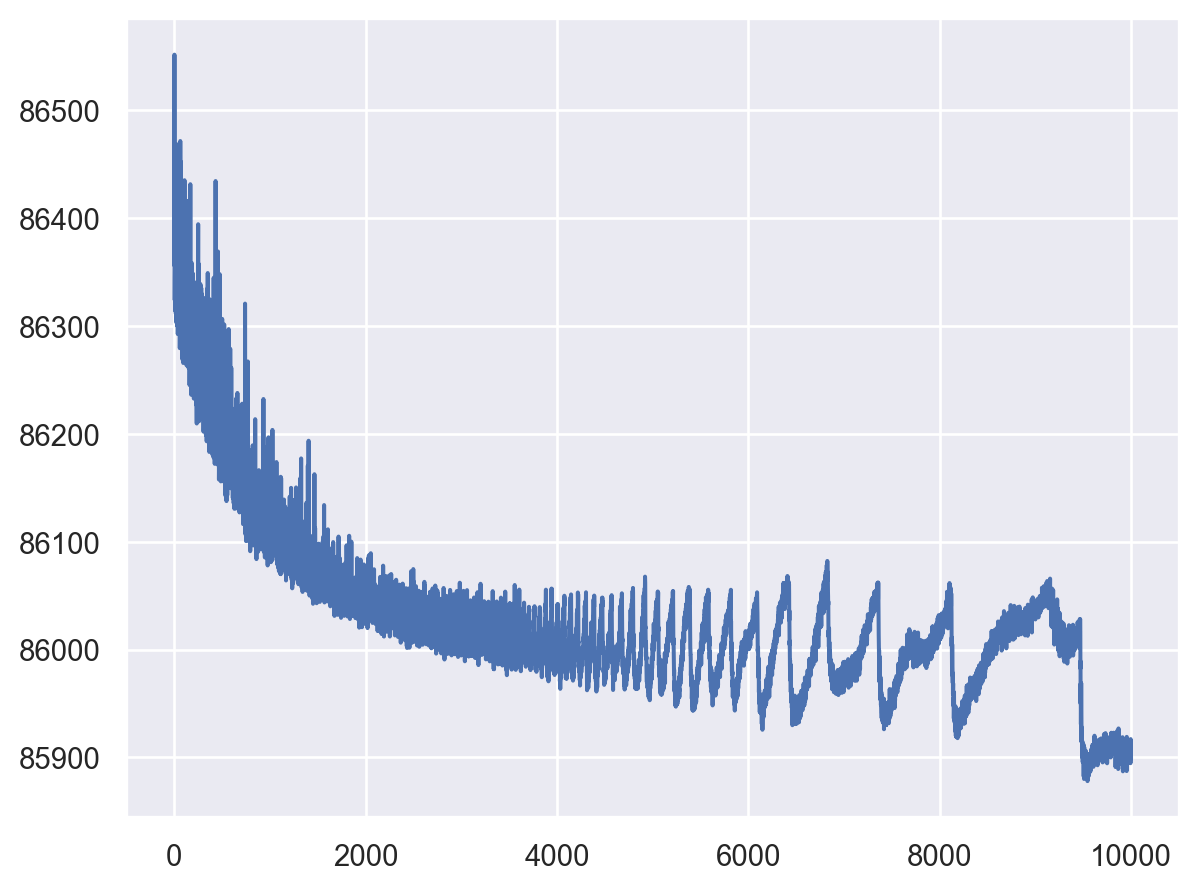

In [32]:
so.Plot(x=range(len(losses)), y=losses).add(so.Line())

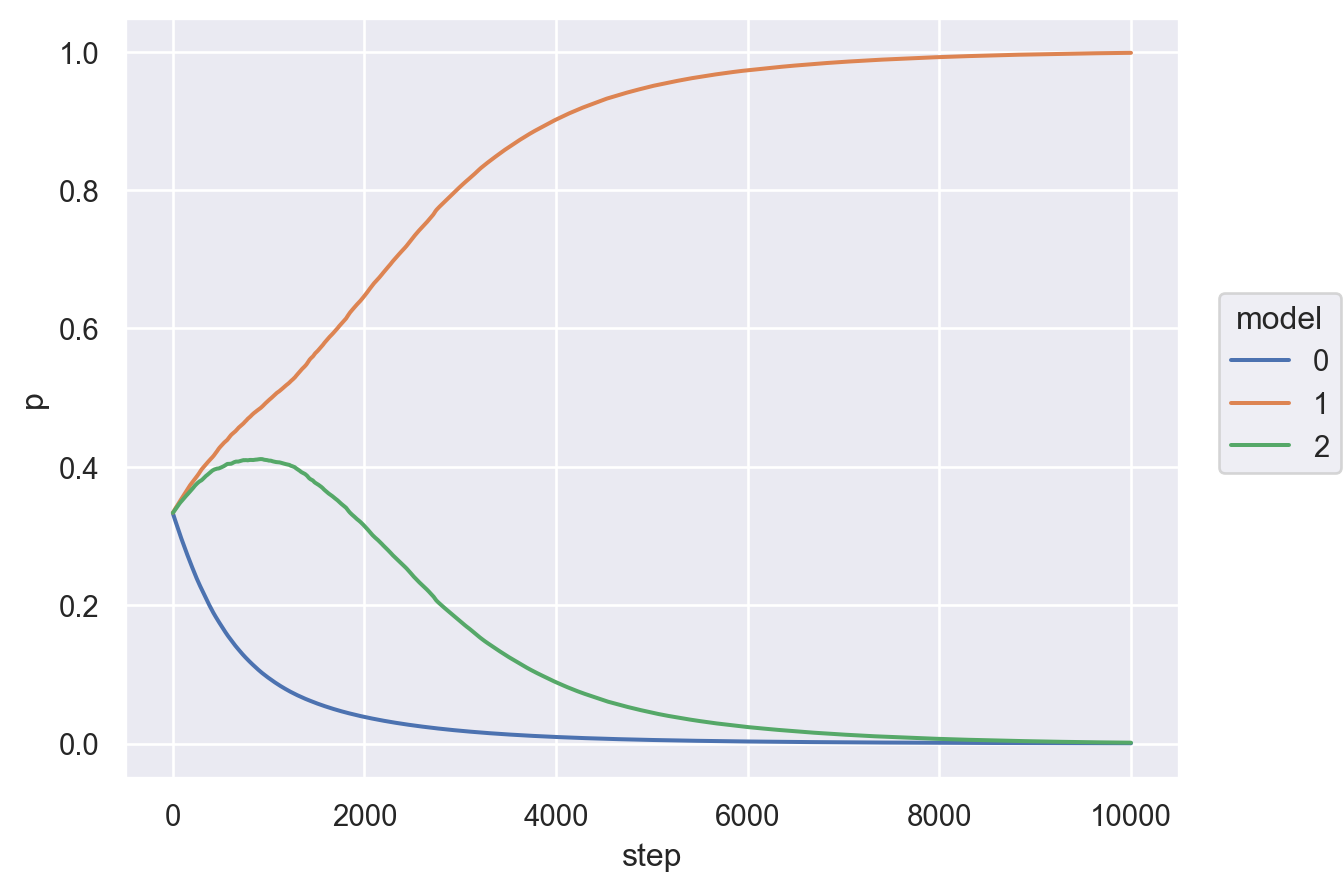

In [33]:
# plot the history of p_model, i.e. the probability assigned to each model during training
df_hist_p_model = (
    pd.DataFrame(data=hist_p_model)
        .reset_index(names="step")
        .melt(id_vars="step", var_name="model", value_name="p")
)
so.Plot(df_hist_p_model, x="step", y="p", color="model").add(so.Line()).scale(color=so.Nominal())

## Stepwise Model Inference (`numpyro`)

In [34]:
def model_meta_numpyro(obs, staff, p0):
    # parameters for global model
    theta_global = numpyro.sample("theta_global", ndist.Beta(0.5, 0.5))

    # parameters for voice model
    with numpyro.plate("voices", 4, dim=-1):
        theta_voice = numpyro.sample("theta_voice", ndist.Beta(0.5, 0.5))

    # parameters for register model
    a = numpyro.sample("a", ndist.Normal(0, 10))
    b = numpyro.sample("b", ndist.Normal(0, 10))
    theta_register = 1 / (1 + jnp.exp(-(p0*a + b)))

    # combine the thetas of different models -> can then be chosen through theta[model_choice]
    theta = jnp.stack((
        jnp.full(p0.shape, theta_global), # model 1
        theta_voice[staff],               # model 2
        theta_register                    # model 3
    ))
    
    # choice of model, uniform between 0 (global), 1 (voice-dependent), and 2 (register-dependent)
    model_choice = numpyro.sample("model", ndist.CategoricalProbs(jnp.ones(3)/3.0), infer={"enumerate": "parallel"})
    
    # make the observations
    with numpyro.plate("observations", size=len(obs)) as i:
        obs = numpyro.sample("obs", ndist.Geometric(Vindex(theta)[model_choice, i]), obs=obs[i])

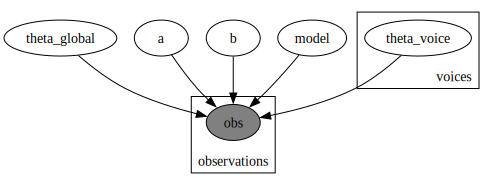

In [35]:
numpyro.render_model(model_meta_numpyro, (jnp.array(observations), jnp.array(staff), jnp.array(p0)))

In [36]:
# define models in numpyro
def model_simple_numpyro(obs):
    theta = numpyro.sample("theta_global", ndist.Beta(0.5, 0.5))
    #jax.debug.print("- theta_global: {t}", t=theta)
    obs = numpyro.sample("obs_global", ndist.Geometric(theta), obs=obs)

def model_voice_numpyro(obs, staff, nstaves=4):
    with numpyro.plate("voices", nstaves):
        theta = numpyro.sample("theta_voice", ndist.Beta(0.5, 0.5))
    #jax.debug.print("- theta_voice: {t}", t=theta)
    obs = numpyro.sample("obs_voice", ndist.Geometric(theta[staff]), obs=obs)

def model_register_numpyro(obs, p0):
    a = numpyro.sample("a", ndist.Normal(0, 10))
    b = numpyro.sample("b", ndist.Normal(0, 10))
    theta = 1 / (1 + jnp.exp(-(p0*a + b)))
    #jax.debug.print("- a: {a}\n- b: {b}", a=a, b=b)
    #jax.debug.print("- theta_register: {t}", t=theta)
    obs = numpyro.sample("obs_register", ndist.Geometric(theta), obs=obs)

# helper model: runs all submodels independently 
def model_joint_numpyro(obs, staff, p0):
    model_simple_numpyro(obs)
    model_voice_numpyro(obs, staff)
    model_register_numpyro(obs, p0)

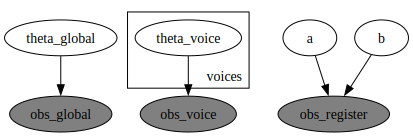

In [37]:
numpyro.render_model(model_joint_numpyro, (jnp.array(observations), jnp.array(staff), jnp.array(p0)))

In [38]:
def run_meta_numpyro(obs, staff, p0):
    obs = jnp.array(obs)
    staff = jnp.array(staff)
    p0 = jnp.array(p0)
    
    n_chains = 2
    n_samples = 5000
    n_warmup = 1000
        
    kernel = numpyro.infer.NUTS(model_joint_numpyro)
    mcmc = numpyro.infer.MCMC(kernel, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains)
    mcmc.run(rng_key, obs, staff, p0)

    # draw samples of the model choice: reuse the posterior samples in the main model
    posterior_samples = mcmc.get_samples()
    predictive = numpyro.infer.Predictive(model_meta_numpyro, posterior_samples, infer_discrete=True, return_sites=["model"])
    discrete_samples = predictive(rng_key, obs, staff, p0)

    # merge model samples
    chain_discrete_samples = jax.tree_util.tree_map(
        lambda x: x.reshape((n_chains, n_samples) + x.shape[1:]),
        discrete_samples)
    mcmc.get_samples().update(discrete_samples)
    mcmc.get_samples(group_by_chain=True).update(chain_discrete_samples)
    
    return mcmc

mcmc_meta = run_meta_numpyro(observations, staff, p0)
idata_meta = az.from_numpyro(mcmc_meta)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [39]:
# no samples of "model" in here, since it's marginalized out
mcmc_meta.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
             a      0.03      0.00      0.03      0.03      0.03   8056.26      1.00
             b     -2.50      0.06     -2.50     -2.60     -2.41   8073.71      1.00
  theta_global      0.32      0.00      0.32      0.31      0.32   9651.69      1.00
theta_voice[0]      0.35      0.00      0.35      0.34      0.36   8251.52      1.00
theta_voice[1]      0.37      0.00      0.37      0.37      0.38   8808.24      1.00
theta_voice[2]      0.34      0.00      0.34      0.33      0.35   8496.03      1.00
theta_voice[3]      0.24      0.00      0.24      0.24      0.25   8919.32      1.00

Number of divergences: 0


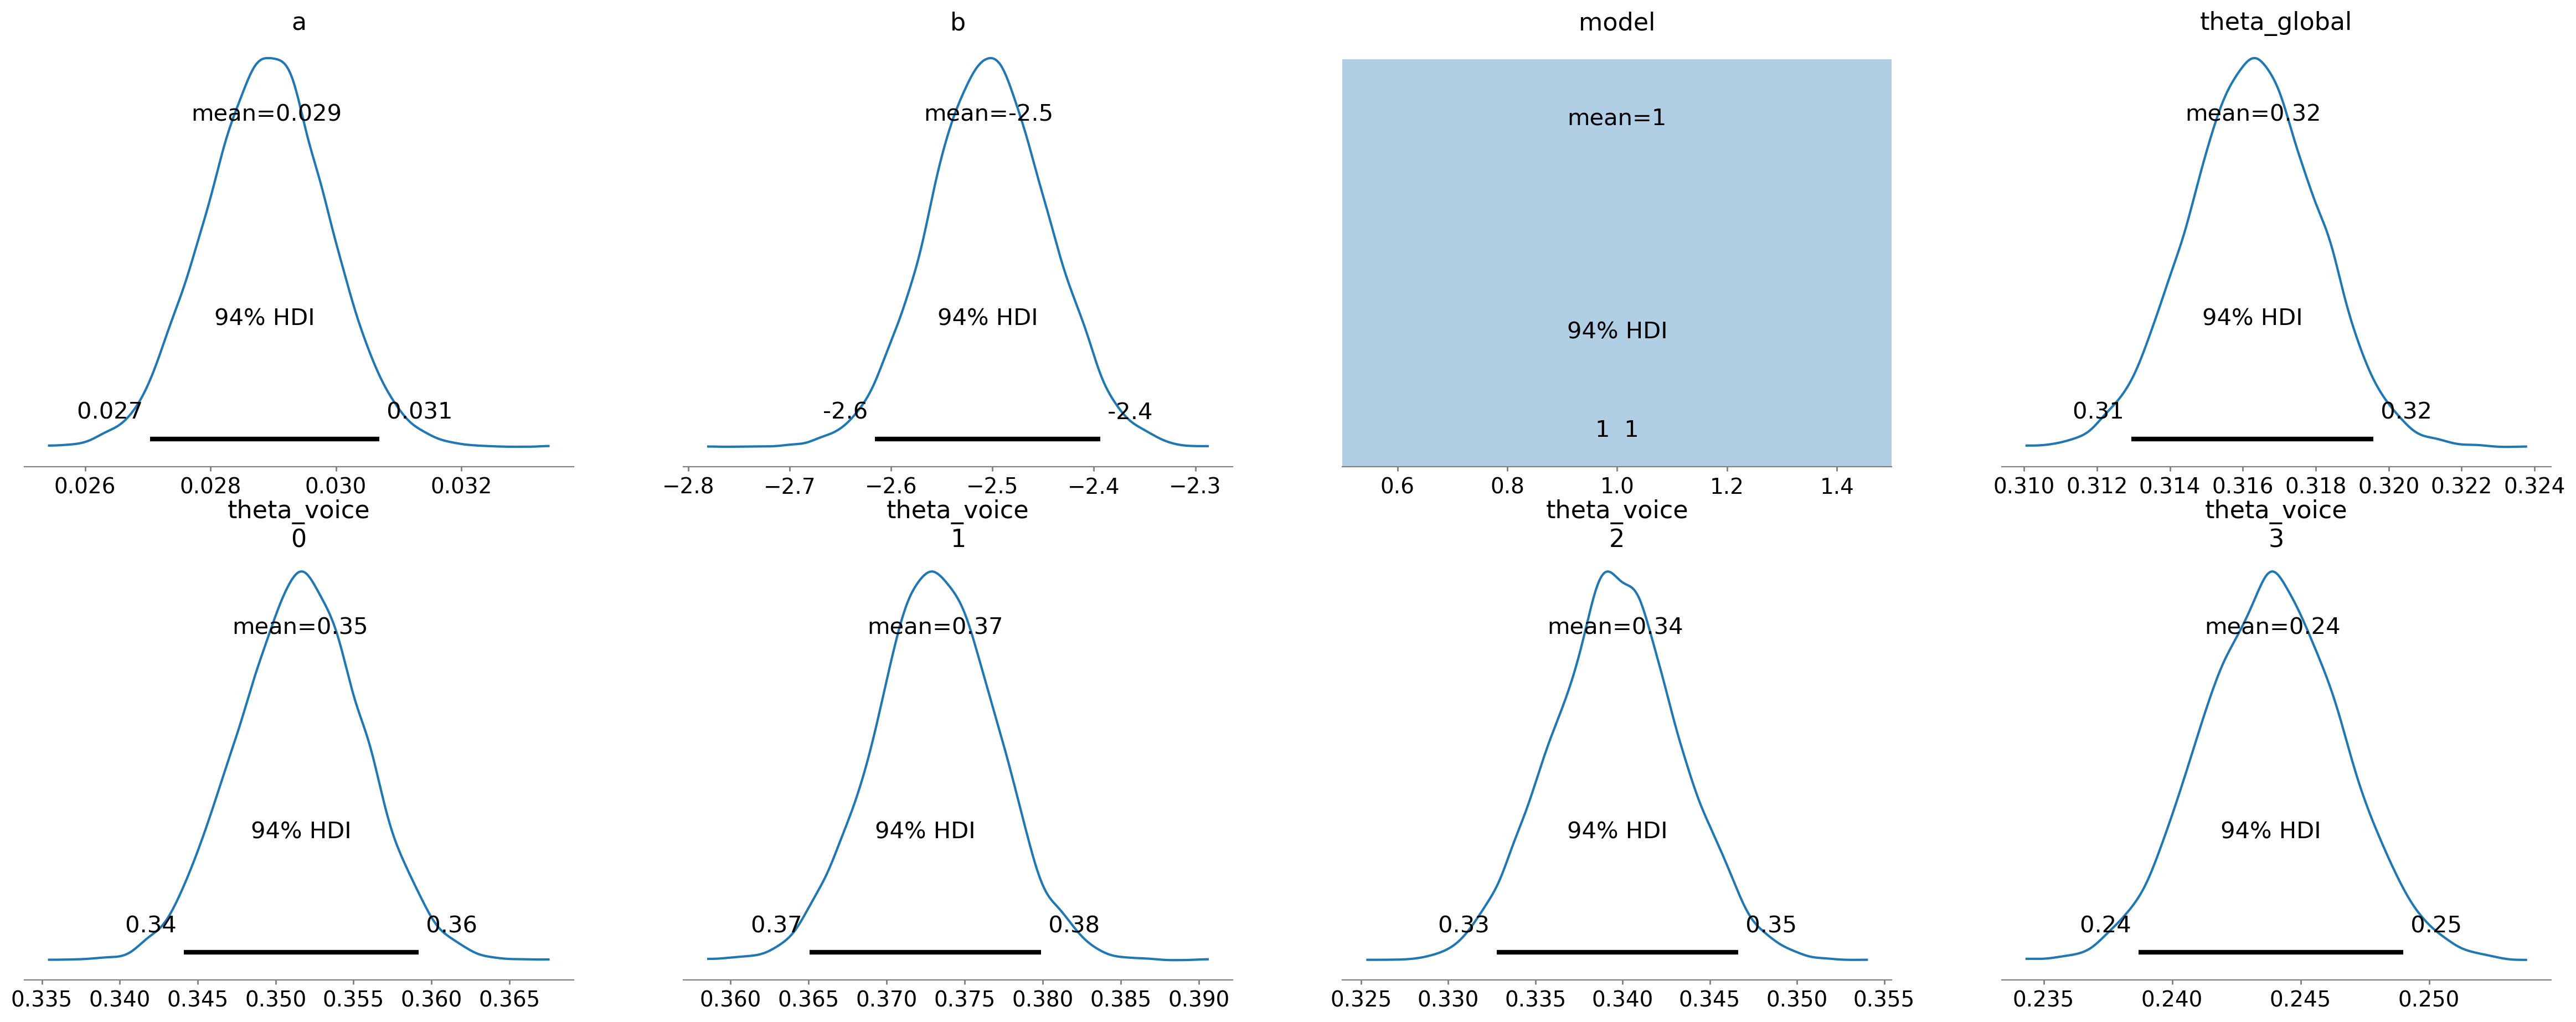

In [40]:
az.plot_posterior(idata_meta);

## Stepwise Model Inference (PyMC) (almost works)

In [ ]:
# Draw samples of the parameters for all 3 models together
with pm.Model() as model_joint:
    # global model
    theta_global = pm.Beta("theta_global", 0.5, 0.5)
    pm.Geometric("obs_global", p=theta_global, observed=observations+1)

    # voice model
    theta_voice = pm.Beta("theta_voice", 0.5, 0.5, shape=4)
    pm.Geometric("obs_voice", p=theta_voice[staff], observed=observations+1)

    # register model
    a = pm.Normal("a", 0, 10)
    b = pm.Normal("b", 0, 10)
    theta_register = pm.math.sigmoid(p0*a + b)
    pm.Geometric("obs_register", p=theta_register, observed=observations+1)

In [ ]:
with model_joint:
    idata_joint = pm.sample(5_000, chains=4)

In [ ]:
az.plot_posterior(idata_joint);

In [ ]:
params_joint = estimate_params(idata_joint.posterior)
params_joint

In [ ]:
# Infer model choice using the parameter samples drawn above
with pm.Model() as model_meta:
    # model choice
    model_choice = pm.Categorical("model_choice", [0.5, 0.3, 0.2])
    
    # global model
    theta_global = pm.Beta("theta_global", 0.5, 0.5)

    # voice model
    theta_voice = pm.Beta("theta_voice", 0.5, 0.5, shape=4)

    # register model
    a = pm.Normal("a", 0, 10)
    b = pm.Normal("b", 0, 10)
    theta_register = pm.math.sigmoid(p0*a + b)

    # observation
    theta = ptn.tensor.stack((
        ptn.tensor.fill(p0, theta_global),
        theta_voice[staff],
        theta_register,
    ))
    pm.Geometric("obs", p=theta[model_choice], observed=observations+1)
    
    print(theta[model_choice].eval())

In [ ]:
with model_meta:
    idata_model_choice_meta = pm.sample_posterior_predictive(idata_joint, var_names=["model_choice"])

In [ ]:
az.plot_posterior(idata_model_choice_meta.posterior_predictive);

In [ ]:
# Infer model choice using the parameter samples drawn above
with pm.Model() as model_meta_updated:
    # model choice
    model_choice = pm.Categorical("model_choice", [0.5, 0.3, 0.2])
    
    # global model
    alpha_g, beta_g = params_joint["theta_global"]
    theta_global = pm.Beta("theta_global", alpha_g, beta_g)

    # voice model
    alpha_v, beta_v = params_joint["theta_voice"]
    theta_voice = pm.Beta("theta_voice", alpha_v, beta_v)

    # register model
    mu_a, std_a = params_joint["a_register"]
    mu_b, std_b = params_joint["b_register"]
    a = pm.Normal("a", mu_a, std_a)
    b = pm.Normal("b", mu_b, std_b)
    theta_register = pm.math.sigmoid(p0*a + b)

    # observation
    theta = ptn.tensor.stack((
        ptn.tensor.fill(p0, theta_global),
        theta_voice[staff],
        theta_register,
    ))
    pm.Geometric("obs", p=theta[model_choice], observed=observations+1)

In [ ]:
with model_meta_updated:
    idata_model_choice = pm.sample(1000)

In [ ]:
idata_model_choice

In [ ]:
az.plot_posterior(idata_model_choice);

In [ ]:
az.plot_trace(idata_model_choice);

## Full Meta-Model Inference (broken)

In [ ]:
# full meta model
with pm.Model() as model_meta_full:
    # choice of model, uniform between 0 (global), 1 (voice-dependent), and 2 (register-dependent)
    model_choice = pm.DiscreteUniform("model", 0, 2)

    # parameters for global model
    theta_global = pm.Beta("theta_global", 0.5, 0.5)

    # parameters for voice model
    theta_voice = pm.Beta("theta_voice", 0.5, 0.5, shape=4)

    # parameters for register model
    a = pm.Normal("a_register", 0, 1_000)
    b = pm.Normal("b_register", 0, 1_000)
    theta_register = pm.math.sigmoid(p0*a + b)

    # choose the theta used for observation
    # (we could also do different kinds of observation in here,
    # but it happens to be the same distribution here, just with different parameters)
    theta = ptn.ifelse.ifelse(
        ptn.tensor.eq(model_choice, 0),
        ptn.tensor.fill(p0, theta_global), # reshape the 0d theta_global to 1d, to match the other thetas
        ptn.ifelse.ifelse(
            ptn.tensor.eq(model_choice, 1),
            theta_voice[staff], # select the theta that corresponds to the voice of each observation
            theta_register))

    print(p0.shape)

    # make the observations
    obs = pm.Geometric("obs", p=theta, observed=observations+1)

    model_meta.debug()
    # print(p0.shape)
    print(model_choice.eval())
    # print(theta_global.shape)
    # print(theta_voice.shape)
    # print(theta_register.shape)
    # print(theta.shape.eval())

In [ ]:
# sample
with model_meta_full:
    samples_meta_full = pm.sample(2_000, chains=4, step=[pm.Metropolis(model_choice, tune=False)])

In [ ]:
az.plot_posterior(samples_meta);

In [ ]:
# sample
with model_meta_full:
    samples_meta_full_prior = pm.sample_prior_predictive()

In [ ]:
az.plot_dist(samples_meta_full_prior.prior["model"])